In [4]:
# File management libraries
import pickle as pkl

# Utilities
import os
from tqdm import tqdm
from typing import Union
from collections import defaultdict
from operator import itemgetter

# Web scraping libraries
import requests
from bs4 import BeautifulSoup

# Data manipulation libraries
import pandas as pd
import numpy as np

# Network analysis libraries
import networkx as nx
import netwulf as nw
from community import community_louvain

# Text processing libraries
import re
import pyphen
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download(["vader_lexicon"])

# Plotting libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

colors = ['#ad262d', '#013d7b', '#e2a226', '#007447', '#4a2222', '#b37a35', '#948ba0', '#dc7d69', '#f6dcb7']

# Custom libraries
from Utils.Swap import ex_modularity
from Utils.get_text import *

# Flatten list function
def flatten(list_list : list) -> list:
    return [item for sublist in list_list for item in sublist]

# Motivation

## What is your dataset?

The raw dataset consisted of data from two sources:
1. The original Harry Potter books taken from: https://github.com/formcept/whiteboard/tree/master/nbviewer/notebooks/data/harrypotter
2. A list of characters Harry Potter characters taken from:
    1. https://harrypotter.fandom.com/wiki/Harry_Potter_and_the_Philosopher%27s_Stone_(character_index)
    2. https://harrypotter.fandom.com/wiki/Harry_Potter_and_the_Chamber_of_Secrets_(character_index)
    3. https://harrypotter.fandom.com/wiki/Harry_Potter_and_the_Prisoner_of_Azkaban_(character_index)
    4. https://harrypotter.fandom.com/wiki/Harry_Potter_and_the_Goblet_of_Fire_(character_index)
    5. https://harrypotter.fandom.com/wiki/Harry_Potter_and_the_Order_of_the_Phoenix_(character_index)
    6. https://harrypotter.fandom.com/wiki/Harry_Potter_and_the_Half-Blood_Prince_(character_index)
    7. https://harrypotter.fandom.com/wiki/Harry_Potter_and_the_Deathly_Hallows_(character_index)

The datasets were collected by using API-requests and Beautifulsoup to scrape the data from the websites. The specific functions used for webscraping can be found in `1.Dataset_files/get_Books.ipynb` as well as `1.Dataset_files/get_Characters.ipynb`. Dataset stats before any preprocessing can be seen below:

In [5]:
len_books = []

book_titles = ["Book 1 - The Philosopher's Stone",
               "Book 2 - The Chamber of Secrets",
               "Book 3 - The Prisoner of Azkaban",
               "Book 4 - The Goblet of Fire",
               "Book 5 - The Order of the Phoenix",
               "Book 6 - The Half Blood Prince",
               "Book 7 - The Deathly Hallows"]

for title in book_titles:
    book = open("Data/OriginalBooks/" + title + ".txt", "r").read()
    len_books.append((len(book.split(" ")), len(book)))

print(f"The raw-book dataset consists of {len(len_books)} books, with {sum([l[0] for l in len_books])} words, and {sum([l[1] for l in len_books])} characters.")
df_characters_raw = pd.read_csv("Data/CharacterData.csv")
print(f"The raw character-list for all 7 books consisted of {len(df_characters_raw)} characters.")

The raw-book dataset consists of 7 books, with 1168851 words, and 6765119 characters.
The raw character-list for all 7 books consisted of 7 characters.


## Why did you choose this/these particular dataset(s)?

It should be no secret that all three of us consider ourselves huge "Potterheads". We have all read and loved the books multiple times. Thus for us, the reasoning behind choosing this dataset was quite simple: We wanted to work with something we were passionate about and had some degree of expert knowledge in. Choosing this dataset, enabled us to work with more advanced network and text analysis techniques, such as temporal analysis of networks and wordclouds and sentiment analysis.

## What was your goal for the end user's experience?

With our dataset, we set out to explore the following key research questions:
1. **HOW DO THE BOOKS CHANGE OVER TIME?**: The Harry Potter books where written by J.K. Rowling and initially published between 26th June 1997 – 21st July 2007. The first book (Harry Potter and the Philosopher's Stone) was originally marketed as a kids-book, but as the next 6 books were published in a span of 10 years, the primary audience of the books grew up. We thus wanted to understand if the topics discussed in the books over time became more complex and more adult. This question is answered by 1) looking at the temporal analysis of the character graphs, to understand if the number of key characters and the number of interactions change over time to address a more mature reader with better memory, and 2) looking at the full book texts through wordclouds and Flesch's Reading Ease score over time to understand if the language and themes discuss become more adult and complex.
2. **HOW DO THE CHARACTERS, THEIR INTERACTIONS / RELATIONSHIPS, AND LANGUAGE SURROUNDING THEM CHANGE THROUGHOUT KEY MOMENTS IN THE HARRY POTTER BOOKS?**: It is no secret that what makes a book or series of book exciting to read are its shocking and exciting key moments, where big changes in character archs happen. We thus wanted to understand how the characters, their interactions and the language surrounding them changed throughout some identified key moments in the Harry Potter books. This question is answered by 1) looking at the temporal analysis of the character graphs, to understand how how key moments have an effect on sub-communities (i.e. changes in alliance), and 2) looking at the book texts that surrounds a character at a specific time through wordclouds and sentiment analysis to understand if they are portrayed in a different light as there character arch developments are uncovered. The pre-defined key moments we will explore in this work are:
    1. The Muggle world vs. the Wizarding world: A magical (pun intended) contrast in the first book is the distinction between the first 3 chapters of book one and the remaining part of the first book. The first 3 chapters are set in the Muggle world, where Harry is treated as an outcast and is bullied by his cousin Dudley. The remaining part of the book is set in the Wizarding world, where Harry is treated as a hero and is loved by everyone. We would thus expect to see a clear distinction in the character graphs (if nothing else, simply because of the sheer amount of new characters introduced in the wizarding world) and the sentiment of the books shifting to being more positive.
    2. The establishment of Dumbledore's Army: In the fifth book, Harry, Ron, Hermione and other Hogwards pupils establish Dumbledore's Army, a secret organisation that teaches students defensive spells to protect themselves against the dark arts as an answer to the reign of terror under the new headmistress Dolores Umbridge. We would thus expect to see a clear distinction in the character graphs, where the members of Dumbledore's Army are more closely connected to each other, and the sentiment of the books shifting to being more hopeful.
    3. Snape's True allegiance: In the ending of book 6, Severus Snape goes on to kill Albus Dumbledore. This is a huge shock to the reader, as Snape has been portrayed as a good guy (if not suspicious) throughout the entire series. However in book 7, it is later revealed that Snape was in fact a double agent, and was working for Dumbledore all along. We would thus expect to see a clear distinction in the character graphs, where Snape is more closely connected to the Death Eaters after killing Dumbledore and then is linked heavily to especially Dumbledore and Lily Potter after his true alliance is revealed. From a text perspective, we would expect to see Snape's portrayal going from neutral, to negative, to positive (if not still somewhat negative, but with a sad tone).
    4. Sirius Black and Peter Pettigrew's true allegiances: Throughout book 3, Sirius Black is treated as a criminal death eater, who is responsible for Voldemort finding and killing Harry's parents, while Peter Pettigrew is described as the hero who died trying to save Harry's parents. Towards the ending of book 3, Sirius Black is revealed to be Harry's godfather and Peter Pettigrew is revealed to be alive and the one who betrayed Harry's parents. We would thus expect to see a clear distinction in the character graphs, where Sirius Black is more closely connected to Harry and the Order of the Phoenix, and Peter Pettigrew is more closely connected to Voldemort and the Death Eaters after this revelation. From the text, we would expect to see Sirius Black's portrayal going from negative, to positive, and Peter Pettigrew's portrayal going from positive, to negative.

In summary, our main goal for the end user's experience was to provide a tool that could help them explore the Harry Potter books in a new and way. We wanted to create new-found excitement in the user's mind about this pheominal books series, and give some reasoning behind what makes them so good, namely its dynamically changing and expanding world of characters, their motives and relationships.

# Basic Stats

## Data cleaning and preprocessing choices

### Data cleaning of the books and character lists

We need to reflect on the data-cleaning choices we made in the context of what we wanted to achieve: Namely to build a character network for each chapter in each book, where the nodes were characters, their size were proportional to the number of times they appeared in the chapter, and the edges were weighted by the number of times two characters appeared on the same page in that chapter. Thus, we needed the books to be split to individual sentences, for us to check the interactions between characters on the same page. We also needed the character lists to be cleaned, so that we could check whether a character was mentioned in a sentence and ensure that all relevant character aliases were included in the character lists.

**1. Cleaning the book texts:**
* Separate the text into chapters by splitting using the chapter headings. Here we used a regex statement to find the chapter headings, but we could also have used the chapter headings from the table of contents, due to spelling mistakes in the chapter headings. The regex statement for the chapter headings was `"\n{9}|\n{8}|\n{7}|\n{6}|\n{5}[0-9]+\s?\n{5}"`. For more details, see the `split_chapters()` function below.
* Separate the text into pages by splitting using the page headings. The regex statement for the page headings was `f"Page \| [0-9]+ {book_title} -\s?J.K. Rowling"`. For more details, see the `split_pages()` function below.
* Separate the page text into sentences by using the `nltk` sentence tokenizer to get a list of sentences for a specific page. For more details, see the `format_page()` function below.	
* Create a dictionary where the keys are the chapter numbers and the values are the nested list of nested lists of text on a specific chapter page sentence. The first sentence of a new page was moved to the previous page, as there was a big chance that this was in fact a part of the last sentence on the previous side. The final function to preprocess the books is thus called using the `book_dict = split_book()` function as seen below. (We realize that this sentence is slightly confusing, but this translates to calling the 10th sentence of the 5th page of the 3rd chapter as `book_dict[3][4][9]`)
* For each book, the `book_dict = split_book()` function was called, and the resulting dictionary was saved as a pickle file. Before saving, it was tested that each `book_dict` had the right number of chapters and pages.


In [6]:
def split_chapter(Book):
    split_string = "\n{9}|\n{8}|\n{7}|\n{6}|\n{5}[0-9]+\s?\n{5}"
    Chapters_text = {idx+1 : chapter for idx, chapter in enumerate(re.split(split_string, Book[7:]))}

    return Chapters_text

def split_pages(Chapter,split_string):
    Pages_text = re.split(split_string,Chapter)
    return Pages_text

def format_page(Page):
    Page = re.sub("\n+|\t","",Page)
    Page = tokenize.sent_tokenize(Page)
    return Page

def split_book(Book,split_string):
    Chapters_text = split_chapter(Book)
    for chapter in Chapters_text:
        Pages_text = split_pages(Chapters_text[chapter],split_string)
        Pages_text = [format_page(Page) for Page in Pages_text[:-1]]
        Chapters_text[chapter] = Pages_text

    for chapter in Chapters_text:
        for idx,page in enumerate(Chapters_text[chapter]):
            if idx == 0:
                continue
            else:
                if not page[0][0].isupper():

                    Chapters_text[chapter][idx-1][-1] = Chapters_text[chapter][idx-1][-1] + " " + page[0]
                    
                    Chapters_text[chapter][idx] = page[1:]
                
    return Chapters_text

The above functions were called using:

```python
book_titles = ["Book 1 - The Philosopher's Stone",
               "Book 2 - The Chamber of Secrets",
               "Book 3 - The Prisoner of Azkaban",
               "Book 4 - The Goblet of Fire",
               "Book 5 - The Order of the Phoenix",
               "Book 6 - The Half Blood Prince",
               "Book 7 - The Deathly Hallows"]

split_string = [
    "Page \| [0-9]+ Harry Potter and the Philosophers Stone -\s?J.K. Rowling",
    "Page \| [0-9]+ Harry Potter and the Chamber of Secrets -\s?J.K. Rowling",
    "Page \| [0-9]+ Harry Potter and the Prisoner of Azkaban -\s?J.K. Rowling",
    "P\s?a\s?g\s?e\s?\|\s?[0-9]+\s?\n*\s?Harry Potter and the Goblet of Fire -\s?J.K. Rowling",
    "P\s?a\s?g\s?e\s?\|\s?[0-9lUO]+\s?\n*\s*Harry Potter and the Order of the Phoenix -\s?J.K. Rowling",
    "P\s?a\s?g\s?e\s?\|\s?[0-9lUO]+\s?\n*\s*Harry Potter and the Half Blood Prince -\s?J.K. Rowling",
    "P\s?a\s?g\s?e\s?\|\s?[0-9lUO]+\s?\n*\s*Harry Potter and the Deathly Hallows -\s?J.K. Rowling"
]

for book_nr, (book_title, split) in enumerate(zip(book_titles, split_string)):
    # Get raw book text
    with open(f"Data/OriginalBooks/{book_title}", encoding="utf8") as f:
        book = f.read()
    
    # Split book using the function into a dictionary
    book_dict = split_book(book)

    # Save book_dict as pickle file
    with open(f"Data/Books formatted/Book{book_nr + 1}.pkl", "wb") as filename:
        pkl.dump(book_dict, filename)
```

**2. Cleaning the character list:**
* The raw character list consisted of a data-frame that included their name, and links. For starters we used the `get_aliases()` function on each character to get a list of the characters webscraped aliases.
* This list of aliases was further enhanced by handling some edge-cases: 1) including edge_case aliases (most commonly the most important characters formal name, i.e. "Mr Potter", or "Professor Dumbledore). This process was done by using the `get_edge_alias()` function and linked to a manually curated list of additional aliases that we knew were present in the books, but had been left out of the fandom alias section. 2) including their first name as an alias. This was done using the `add_first_name()` function, and again included some edge cases that where handled. These edge cases typically centered around the characters first name being a descriptive word such as "Mr." and "Mrs" instead of an actual name.
* Next we focused on cleaning the data further by removing duplicate characters. We manually curated the list `potential_dublicates.txt` that contained the names of all the characters where one of their aliases was the same as another characters name. We then used the `remove_dublicates()` function to remove these characters from the list. There are several reasons for dublicate character names, two major once being 1) that smaller sub-characters in the fandom wiki did not have their separate wiki-pages, but where included into the same overarching page, and that especially Harrys kids in the last book are named after his parents and other important characters. This design choice was made because we didn't want the character graphs and dynamic text later to ascribe the presence of a character to two different characters. This further meant that we excluded some characters, mainly the small characters and Harrys kids, from the analysis.
    * While removing the dublicates, we also ensure that we remove aliases that are the same as another characters name. This was done using the `remove_alias_same_as_name()` function.
    * We further add the characters full name to the list of aliases, to ensure that we can later just search for the character based on its alias list. This was done using the `add_name()` function.
    * We finally traverse all alias lists backwards and remove any alias that is present in an earlier mentioned characters aliases list. This was done using the `remove_dublicate_aliases()` function. The backwards traversal is under the assumption that the first mentioned character is the most important one, and thus any dublicate aliases with later characters should be ascribed to the first mentioned character.

In [7]:
def get_edge_alias(character: str = 'Harry Potter', alias_list: list = []):
    with open("Temp/character_aliases_edgecases.pkl", "rb") as f:
        edge_aliases = pkl.load(f)

    if character in edge_aliases.keys():
        alias_list.append(edge_aliases[character])
    
    return alias_list

def add_first_name(character: str = 'Harry Potter', alias_list: list = []):
    none_aliases = ['A', 'Mr', 'Mrs', 'Dr', 'Manager', 'The', 'Father','Sorting', 'wizard', 'Chancellor', 'Workmen', 'Waitress', 'Sir',
                    'Nearly-Headless', 'Fat','Aged', 'Blood-Sucking', 'Forbidden','Unidentified', 'Zoo', 'Kepper', 'Muggle', 'Muggle-Born',
                    'Senior', 'Junior', 'Board', 'Committee','Academy', 'Ministry', 'Department',
                    'Little', 'Great', 'Old', 'Young', 'Head', 'Headmaster', 'Headmistress','Weird','Care', 'Montgomery', 'Hogwarts', 'Frank']
    
    none_name = ["'s", "s'", "family"]

    if ((character.split(' ')[0] not in none_aliases) and (all([s not in character for s in none_name])) and (character.split(' ')[0].isalpha())):
        alias_list.append(character.split(' ')[0])
    
    return alias_list

def get_aliases(character: str = 'Harry Potter', link: str = '/wiki/Harry_Potter', df: pd.DataFrame = pd.DataFrame()):
    query = requests.get(f"https://harrypotter.fandom.com/api.php?action=parse&page={link.split('/')[-1].split('#')[0]}&format=json").json()
    HTML = query['parse']['text']['*']
    soup = BeautifulSoup(HTML, 'html.parser')

    # Get aliases
    try:
        # Character has aliases
        alias_ = soup.find(string='Also known as').findNext("div")
        if alias_.find_all('li') != []:
            # Character has multiple aliases
            alias_ = [i.get_text() for i in alias_.find_all('li')]
            alias_ = [re.split('\s?(\()|(\[)',j)[0] for j in alias_]
        else:
            # Character has only one alias
            alias_ = [re.split('\s?(\()|(\[)',alias_.get_text())[0]]
    except:
        # Character has no aliases
        alias_ = []

    # Ensure that aliases are not the same as a character name
    alias_ = [i for i in alias_ if not df['Name'].str.contains(f'{i}', regex=False).any()]

    # Add edge cases and first name
    alias_ = get_edge_alias(character = character, alias_list = alias_)
    alias_ = add_first_name(character = character, alias_list = alias_)

    # Ensure that aliases are unique and not the same as the character's name
    alias_ = list(set(alias_))
    alias_ = [i for i in alias_ if i != character]

    return alias_

In [8]:
def remove_alias_same_as_name(alias_list: list = [], character_Names: list = []):
    # Remove aliases that are the same as character names
    alias_list = [i for i in alias_list if i not in character_Names]

    return alias_list

def add_name(alias_list: list = [], character_name: str = ''):
    # Add character name to alias list
    alias_list.append(character_name)
    list(set(alias_list))
    return alias_list

def remove_dublicate_aliases(alias_list: list = [], all_previous_character_aliases: list = []):
    # Remove duplicate aliases
    alias_list = [i for i in alias_list if i not in all_previous_character_aliases]
    return alias_list

def remove_dublicates(character_df: pd.DataFrame, remove_character: list = []):
    # remove duplicate characters
    for character in remove_character:
        character_df = character_df[character_df['Name'] != character]

    character_df.reset_index(drop=True, inplace=True)

    for idx, character in enumerate(character_df['Name']):
        character_df.loc[idx, 'Aliases'] = remove_alias_same_as_name(alias_list = character_df.loc[idx, 'Aliases'],
                                                                     character_Names = character_df['Name'].tolist())
    
        character_df.loc[idx, 'Aliases'] = add_name(alias_list = character_df.loc[idx, 'Aliases'], character_name = character_df.loc[idx, 'Name'])
    
    for i in range(len(character_df), -1, -1):
        aliases = [alias for aliases in character_df.loc[:i, 'Aliases'] for alias in aliases]
        character_df.loc[i, 'Aliases'] = remove_dublicate_aliases(alias_list = character_df.loc[i, 'Aliases'],
                                                                  all_previous_character_aliases = aliases)
                                                                
    return character_df

The above code is called using:

```python

# Loading the raw character list
character_df = pd.read_csv("Data/CharacterData.csv")

# Getting the aliases for each character
aliases = [get_aliases(character = i, link = j, df = character_df) for i,j in tqdm(zip(character_df['Name'], character_df['Link']))]
character_df['Aliases'] = aliases

# Optionally save the character_df as CharacterWikis.csv
character_df.to_csv("Data/CharacterWikis.csv", index = False)

# Optionally load the character_df as CharacterWikis.csv
character_df = pd.read_csv("Data/CharacterWikis.csv")
character_df.Aliases = [eval(char) for char in character_df.Aliases]

# Load the potential dublicates text file
with open("Data/potential_dublicates.txt","r") as f:
    potential_dublicates = f.readlines()
    potential_dublicates = [char.strip() for char in potential_dublicates]
    remove_char = [char[:-4] for char in potential_dublicates if char[-3:] == "(R)"]

# Remove the dublicates
character_df = remove_dublicates(character_df, potential_dublicates)

# Save the character_df as CharacterWikis_clean.csv
character_df.to_csv("Data/CharacterWikis_clean.csv", index = False)
```

In [9]:
# Load formatted book (dict of chapters with list of lists of pages and sentences)
initial_character_list = pd.read_csv("Data/CharacterWikis.csv")
final_character_list = pd.read_csv("Data/CharacterWikis_clean.csv")
final_character_list.Aliases = [eval(char) for char in final_character_list.Aliases]

print(f"The initial character list has {len(initial_character_list)} characters, and {sum([len(eval(l)) for l in initial_character_list['Aliases']]) + len(initial_character_list)} aliases in total.")
print(f"The final character list after data cleaning has {len(final_character_list)} characters, and {sum([len(l) for l in final_character_list.Aliases])} aliases in total.")

The initial character list has 707 characters, and 1393 aliases in total.
The final character list after data cleaning has 677 characters, and 1323 aliases in total.


### Pre-processing to set up the dynamic chapter networks

With the character lists in place, and the books cleaned, we are now ready to create the network graph that we wish to analyze. Since we will need multiple graphs for the different analyses we will perform later, the first useful graph we can look at contains the complete network of each book. Additionally, we wish to be able to differentiate between the chapters for said books in order to keep track of where each appearance and connection between characters take place.

The various functions used to create the graphs can be seen below. These functions are:
* `get_edge_chapter_weight(character1, character2, chapter)`: function to calculate the edge weight between two lists of characters
* `get_edge_book_weight(character1, character2, book)` function to get the edges between two characters for a given book. This is done by looping over all chapters of the book whilst calling the `get_edge_chapter_weight()` function.
* `get_node_size(character, book)`: function to loop over every chapter in a book to calculate the total appearances of every character. 

In [10]:
def get_edge_chapter_weight(character1: list, character2: list, chapter: list):
    weight = 0
    for page in chapter:
        page_text = ' '.join(page)
        if any([char in page_text for char in character1]) and any([char in page_text for char in character2]):
            weight += 1
    
    return weight

def get_edge_book_weight(character1: list, character2: list, book: dict):
    weight = defaultdict(int)
    for chapternr in range(1, len(book)+1):
        weight[chapternr] = get_edge_chapter_weight(character1, character2, book[chapternr])
    return weight

def get_node_size(character: list, book: dict):
    size = defaultdict(int)
    for chapternr, chapter  in book.items():
        for page in chapter:
            page_text = ' '.join(page)
            if any([char in page_text for char in character]):
                size[chapternr] += 1
    return size

The networks were then created by looping over the different books and combining the above functions to create a dictionary of graphs for each book. This process is seen in the loop below:

```python
Book_networks = {}

for book_nr in range(1,8):
    # Load formatted book (dict of chapters with list of lists of pages and sentences)
    with open(f"Data/Books formatted/Book{book_nr}.pkl","rb") as f:
        book = pkl.load(f)

    print(f"Creating book graph for book {book_nr}...")

    # Draw network
    G = nx.Graph()

    # Add nodes to graph
    for character in tqdm(characters, desc='Adding character nodes to graph...'):
        character['sizes'] = get_node_size(character['aliases'], book)
        G.add_node(character['name'], sizes=character['sizes'], attr=character['aliases'])

    # Add edges to graph
    for i, char1 in enumerate(tqdm(characters, desc='Adding edges to graph...')):
        for j, char2 in enumerate(characters[i+1:]):
            edge_weight = get_edge_book_weight(char1['aliases'], char2['aliases'], book)
            if sum(edge_weight.values()) != 0:
                G.add_edge(char1['name'], char2['name'], weight=edge_weight)

    # Save graph
    Book_networks[book_nr] = G.copy()
```

This dictionary of networks contain networks corresponding to each book. Each of these networks have nodes and edges that consist of character appearances- and co-appearances. Each of the nodes contain the attributes `name`, `size`, `aliases` and implicitedly `chapter_nr` due to the sizes and edge weights being a dictonary with chapter numbers as keys. Therefore the network can be used to find the network state at a specific point in time in the books.

### Preprocessing to set up the dynamic character text

On the text side, we wanted to have a dynamic text base ascribed to each character, that considered a context window of text around an instance of that characters occurance as measured by one of that characters aliases being mentioned. 

This was done by the following steps looping over each book:
* `text_page(char, page)`: function to get the dynamic text for a given character on a page. For each sentence on the page, the function checks if the character is mentioned (through it's aliases). If it is, the function adds the sentence to the dynamic text, and adds the sentence before and after to the dynamic text as well. This is done to ensure that the context of the character mentioning is included in the dynamic text. Since we are interested in using the character texts for both sentiment analysis and text mining usind TF-IDF visualized through wordclouds, we need to balance out the context size between these two tasks. Researchers such as Karbasi &Boughanem (2006), have found that TF-IDF struggles with collections of long documents, due to increasing changes of homogeneity. They additionally note that large document length variences in a collection can cause several TF-IDF score related issues, as the longer documents dilute the effect of rare terms. Meanwhile, Karbasi & Smeaton (2010) find that shorter written documents can be easier to analyze semantically, as they are more likely to be focused on a single topic. We therefore want to limit the size of the context window surrounding a character occurance, while still capturing meaning related to the character occurance. Therefore, we have chosen to use a context size of 1 sentence. Some initial testing of context sizes, revealed that this gave us a good balance of capturing the context of the character occurance, while still limiting the size of the dynamic text and any possible text homogeneity.
* `text_chapter(char, chapter)`: wrapper function to call the `text_page()` function and return the dynamic text for a given character.
* `tokenize(text)`: function to tokenize the text using the `nltk.stopwords` package. Returns the text as a list of individual lowercased words.
* `tokenize_text(text)`: wrapper function to call tokenize the text using the `tokenize(text)` function by looping through the character occurances.
* `text_book(char, book)`: wrapper function to call the other functions and return the dynamic text for a given character `char` in a given book as a dictionary of chapter numbers as keys and nested lists of all tokenized character occurances as values.

References: 

Karbasi, S., Boughanem, M. (2006). Document Length Normalization Using Effective Level of Term Frequency in Large Collections. In: Lalmas, M., MacFarlane, A., Rüger, S., Tombros, A., Tsikrika, T., Yavlinsky, A. (eds) Advances in Information Retrieval. ECIR 2006. Lecture Notes in Computer Science, vol 3936. Springer, Berlin, Heidelberg. https://doi-org.proxy.findit.cvt.dk/10.1007/11735106_8

Bermingham, A., Smeaton, A. (2010). Classifying Sentiment in Microblogs: Is Brevity an Advantage?. In Proceedings of the 19th ACM international conference on Information and knowledge management - CIKM '10. https://doi-org.proxy.findit.cvt.dk/10.1145/1871437.1871741

In [11]:
def text_page(char : list, page : list) -> list:
    text = []
    for i,line in enumerate(page):
        if any(alias in line for alias in char):
            if i == 0:
                try:
                    text.append([page[i], page[i+1]])
                except:
                    text.append([page[i]])
            elif i == len(page)-1:
                text.append([page[i-1], page[i]])
            else:
                text.append([page[i-1], page[i], page[i+1]])
            
    return text

def text_chapter(char : list, chapter : list) -> list:
    text = []
    for page in chapter:
        text.append(text_page(char, page))
    
    return text

def tokenize(text):
    # Exclude punctuation and numbers and set everything to lower case and exclude stopwords
    text = word_tokenize(text)
    text = [w.lower() for w in text if w.isalpha()]
    text = [w for w in text if not w.lower() in set(stopwords.words('english'))]

    return text

def tokenize_text(text : list) -> str:
    text_tokenized = []

    for page in text:
        for finding in page:
            for sentence in finding:
                text_tokenized.extend(tokenize(sentence))
    
    return text_tokenized

def text_book(char : list, book : list) -> dict:
    text = {}
    for chapnr,chapter in book.items():
        text[chapnr] = tokenize_text(text_chapter(char, chapter))
    
    return text

The above code was called using the below statements:

```python
characters_df = pd.read_csv("Data/CharacterWikis_clean.csv")

characters_dynamic_text = {}

for char in tqdm(characters_df):
    char_book_text = {}

    for book_nr in range(1,8):
        # Load formatted book (dict of chapters with list of lists of pages and sentences)
        with open(f"Data/Books formatted/Book{book_nr}.pkl","rb") as f:
            book = pkl.load(f)
        
        char_book_text[book_nr] = text_book(char['aliases'], book)

    characters_dynamic_text[char['name']] = char_book_text

with open(f"Temp/Dynamic_text.pkl","wb") as f:
    pkl.dump(Characters_dynamic_text,f)

```

### Limitations to data cleaning and preprocessing choices
To round off the data cleaning and preprocessing section, we will discuss some of the limitations to our choices.

Firstly, when it comes to data cleaning, there are several instances of large manual workload in our character-lists, that rely on our expert knowledge of the books, since we manually assign specific character aliases to specific characters and remove any dublicates. As this character list is the guide we use to later find character occurances in the text, this means that any errors in this list will be reflected in the dynamic text and network analysis. This is a limitation to our data cleaning, as it is a manual process that is prone to human error.

Secondly, when it comes to cleaning the books, we break it down to the individual sentence level. This is a very narrow scope, which means that we are able to capture the context of a character occurance, but it also means that we are not able to capture the context of a character occurance on a larger scale, such as a paragraph or a page. Additionally, we leave the text as is, without checking for any spelling errors or dialect differences. This can potentially led to some errors in the dynamic text, as some TF-IDF scores might not fully reflect their importance to the text, due to spelling errors or dialect differences.

Thirdly, in the network pre-processing, an interaction between two characters is defined as two characters appearing on the same page. This might give us very aggressive interaction estimates, as a typical interaction between two characters in the books in reality probably plays out over several pages. This might give us a skewed view of the interactions between characters, as characters involved in long interactions are tied very closely together.

Finally, in the dynamic text preprocessing, the context window is set to +-1 sentence. While we believe that this choice has been validated both theoretically, and empirically, it is still a choice that is made. This means that there is a risk that the context window is either too large or too small, and that it therefore either includes too much or too little context. This could potentially skew the results of the sentiment analysis and the TF-IDF analysis.

## Final dataset stats
We round of the dataset section by presenting some statistics on the final datasets.

In [12]:
# Network
with open("Temp/Book_networks.pkl", "rb") as f:
    book_networks = pkl.load(f)

# Text
with open("Temp/Dynamic_text.pkl", "rb") as f:
    book_text = pkl.load(f)

### Network statistics
For the network analysis, we can move over the 7 networks and get some quick statistics on the number of nodes and edges in each network. We can also get the average degree of each network, which is the average number of edges connected to each node, as well as the network centralization, which is a measure of how centralized the network is. The below figure shows the evolution of these four statistics for each book_network (aggregation of the chapter networks that have been created).

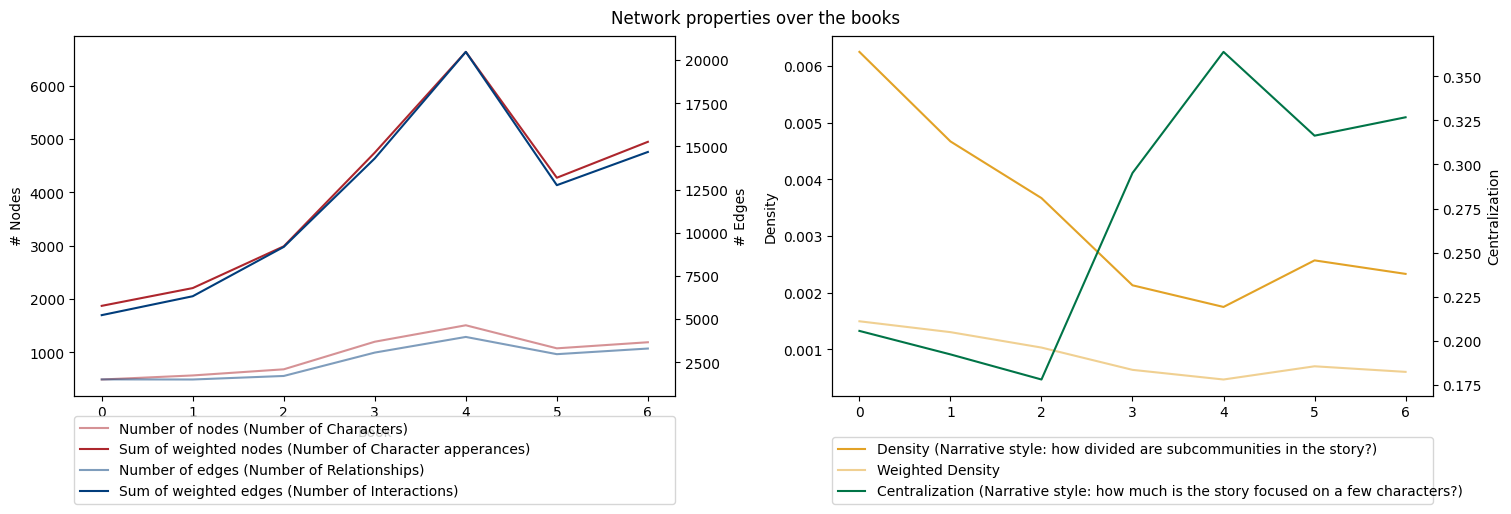

In [13]:
def getCentralization(centrality):
    n_val = float(len(centrality))
    c_denominator = (n_val-1)*(n_val-2)
    
    c_node_max = max(centrality.values())
    c_sorted = sorted(centrality.values(), reverse=True)
    c_numerator = sum([(c_node_max*(n_val-1) - value*(n_val-1)) for value in c_sorted])
    
    return float(c_numerator/c_denominator)

sizes = np.array([len([n for s in book.nodes.data('sizes') for n in s[1] if n != 0]) for book in book_networks.values()])
sizes_w = np.array([sum([sum(s[1].values()) for s in book.nodes.data('sizes')]) for book in book_networks.values()])

edges = np.array([book.number_of_edges() for book in book_networks.values()])
edges_w = np.array([sum([sum(w[2].values()) for w in book.edges.data('weight')]) for book in book_networks.values()])

centralitization = np.array([getCentralization(nx.degree_centrality(book)) for book in book_networks.values()])

fig, ax = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
ax[0].plot(sizes, label = "Number of nodes (Number of Characters)", color = colors[0], alpha = 0.5)
ax[0].plot(sizes_w, label = "Sum of weighted nodes (Number of Character apperances)", color = colors[0])
ax0_2 = ax[0].twinx()

ax0_2.plot(edges, label = "Number of edges (Number of Relationships)", color = colors[1], alpha = 0.5)
ax0_2.plot(edges_w, label = "Sum of weighted edges (Number of Interactions)", color = colors[1])
ax[0].set_xlabel("Book")
ax[0].set_ylabel("# Nodes")
ax0_2.set_ylabel("# Edges")

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax0_2.get_legend_handles_labels()
ax0_2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0., -0.3, 1., .102), loc='lower left',
              ncol=1, mode="expand", borderaxespad=0.)

ax[1].plot((1*edges)/(sizes*(sizes-1)), label = "Density (Narrative style: how divided are subcommunities in the story?)", color = colors[2])
ax[1].plot((1*edges_w)/(sizes_w*(sizes_w-1)), label = "Weighted Density", color = colors[2], alpha = 0.5)
ax1_2 = ax[1].twinx()
ax1_2.plot(centralitization, label = "Centralization (Narrative style: how much is the story focused on a few characters?)", color = colors[3])
ax[1].set_ylabel("Density")
ax1_2.set_ylabel("Centralization")

lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax1_2.get_legend_handles_labels()
ax1_2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0., -0.3, 1., .102), loc='lower left',
              ncol=1, mode="expand", borderaxespad=0.)

fig.suptitle("Network properties over the books")
plt.show()

We see that the number of nodes and edges increase for each book, as more characters are introduced. We also see that the density increases for each book, as the number of edges increase faster than the number of nodes. It is rather interesting to see that the nodes and edges grow by after the same trend, but just at different orders of magnitude. Finally, we see that the network centralization decreases for each book, as the networks become more decentralized. This is due to the fact that the number of edges increase faster than the number of nodes, which means that the networks become more dense, and therefore more decentralized.

From a network perspective, this means that the networks become more complex and decentralized as the books progress, which is in line with the narrative of the books, as the story as the books introduce more side characters and subplots.

### Dynamic text statistics
For the dynamic text analysis, we can get some quick statistics on the number of words in each character's dynamic text. The below figure shows the evolution of the number of words in each character's dynamic text for each book.

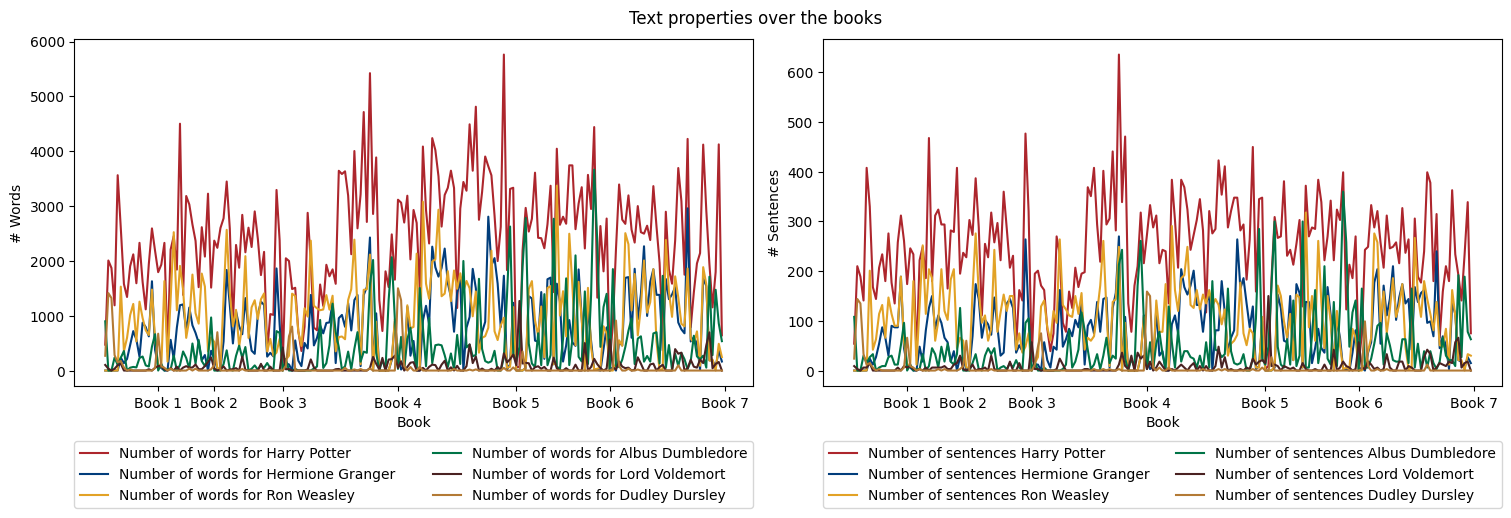

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)

x_ticks = np.cumsum([(len(book_text['Harry Potter'][book_nr])) for book_nr in range(1,8)])

for i, character in enumerate(['Harry Potter', 'Hermione Granger', 'Ron Weasley', 'Albus Dumbledore', 'Lord Voldemort', 'Dudley Dursley']):
    number_of_words = []
    number_of_sentences = []
    for book_nr in range(1,8):
        number_of_words.extend([len(wordlist['tokens']) for wordlist in book_text[character][book_nr].values()])
        number_of_sentences.extend([len(sentences['text'])*3 for sentences in book_text[character][book_nr].values()])
    
    ax[0].plot(number_of_words, label = f"Number of words for {character}", color = colors[i])
    ax[1].plot(number_of_sentences, label = f"Number of sentences {character}", color = colors[i])

    ax[0].set_ylabel("# Words")
    ax[1].set_ylabel("# Sentences")

    for j in range(2):
        ax[j].set_xlabel("Book")
        ax[j].set_xticks([])
        ax[j].set_xticks(x_ticks, labels=[f"Book {i}" for i in range(1,8)])
        ax[j].legend(bbox_to_anchor=(0., -0.35, 1., .102), loc='lower left',
                    ncol=2, mode="expand", borderaxespad=0.)

fig.suptitle("Text properties over the books")
plt.show()


From the sentence and word counts over time for specific characters, we notice that the number of words and sentences variate heavily from chapter to chapter between characters. Some characters (i.e. Harry Potter) are clearly are more prominent in the story, than others. It is also clear that some characters are very "seasonal". For instance, Dudley Dursley seems to have more words and sentences ascribed to him at the beginning of each book, when Harry is typically in the muggle world.

The above figure reveals that the text analysis will need to be heavily guided by the network analysis, as it will only make sense to complete sentiment analysis and TF-IDF analysis on the characters that are prominently featured in the text (and therefore have a large node size in the network) for a specific chapter.

# Tools, theory and analysis

## Tools and theory for Network analysis

### Getting the Character Network at a specific point in the book

In order to carry out analysis of key moments in the history of Harry Potter we need to extract the network of characters at different points in the books. We will do this by creating a function that takes a book and chapter, then returns a network of characters.

To carry out temporal analysis of the expanding network troughout the history of all books, we accumulate the size of the nodes for each character graph up to and including our current chapter. This will give us a measure of the size of the network at each point in the book. We can then plot this to see how the network grows over time. Further the edges can be accumulated for the same chapters where the weigth of an edge in the next chapter is added to weigth of the previous to see how the number of interactions between characters grows over time.

For specific key point in the history it can be preferable to look at the accumulated network for lesser intervals of chapters than the whole book. For instance, we might want to look at the network of characters in the first book before and after Harry goes to Hogwarts. To do this, we can use the same function as before but instead of accumulating the network over the whole book we can accumulate it over a smaller interval of chapters.

This functionality is implemented with `get_network_state(book_nr, chapter_nr, book_only = False, chapter_from = None)` where if `book_only = True` the network is accumulated over the whole book and if `book_only = False` the network is accumulated over all 7 books upto the given point, starting at the first chapter of the first book. If `chapter_from = None` the network is accumulated over the interval from the first chapter to `chapter_nr`. (Note if `book_only = False` then `chapter_from` is ignored)

Using the lovain community detection algorith best partitioning of the network is also found and returned in the `get_louvain_partitioning` function, which is called inside of `get_network_state` for the chapter graph and aggregate graph. This is done by using the `community_louvain.best_partition` function from the `python-louvain` package. The best partition is found by maximizing the modularity of the network. The modularity is a measure of the quality of a partition of a network into communities. The best partition is returned as a dictionary where the keys are the nodes and the values are the community labels.

In [15]:
def get_louvain_partitioning(G):
    partition = community_louvain.best_partition(G)

    # Add partition to graph
    for node in G.nodes:
        G.nodes[node]['group'] = partition[node]
    
    return G, partition


def get_network_state(book_nr, chapter_nr, book_only = False, chapter_from = None):

    # Number of chapters per book
    n_chapters = {1 : 17, 2 : 18, 3 : 22, 4 : 37, 5 : 38, 6 : 30, 7 : 37}

    # Check for valid input
    if book_nr not in range(1,8):
        raise ValueError("book_nr must be between 1 and 7")
    if chapter_nr not in range(1, n_chapters[book_nr]+1):
        raise ValueError(f"chapter_nr must be between 1 and {n_chapters[book_nr]} for book {book_nr}")

    # Add nodes and edges to G_chapter
    G_chapter = nx.Graph()
    G_chapter.add_nodes_from([(node[0], {'size': node[1]['sizes'][chapter_nr], 'attr': node[1]['attr']})
                            for node in book_networks[book_nr].nodes(data=True) if node[1]['sizes'][chapter_nr] != 0])

    G_chapter.add_weighted_edges_from([(edge[0], edge[1], edge[2]['weight'][chapter_nr])
                                        for edge in book_networks[book_nr].edges(data=True) if edge[2]['weight'][chapter_nr] != 0])
    
    G_chapter, partition_chapter = get_louvain_partitioning(G_chapter)

    # Add all characters to graph G
    G = nx.Graph()
    G.add_nodes_from([(c.Name, {'attr': c.Aliases}) for c in final_character_list.itertuples()], size = 0)

    # Update node sizes and edge-weights for G
    if book_only == False:
        G.add_nodes_from([(c.Name, {'size': sum([sum(book_networks[book].nodes[c.Name]['sizes'].values()) for book in range(1, book_nr)])})
                           for c in final_character_list.itertuples()])
        
        for book in range(1, book_nr):
            for node1, node2, weight in book_networks[book].edges.data('weight'):
                if G.has_edge(node1, node2):
                    G.edges[node1, node2]['weight'] += sum(weight.values())
                else:
                    G.add_edge(node1, node2, weight=sum(weight.values()))
        
        for character in final_character_list.itertuples():
                G.nodes[character.Name]['size'] += sum(book_networks[book_nr].nodes[character.Name]['sizes'][i] for i in range(1, chapter_nr + 1))
        
        for node1, node2, weight in book_networks[book_nr].edges.data('weight'): 
            if sum(list(weight.values())[1:chapter_nr+1]) != 0:
                if G.has_edge(node1, node2):
                    G.edges[node1, node2]['weight'] += sum(list(weight.values())[1:chapter_nr+1])
                else:
                    G.add_edge(node1, node2, weight = sum(list(weight.values())[1:chapter_nr+1]))

    else:
        
        if chapter_from == None:
            chapter_from = 1
        
        for character in final_character_list.itertuples():
                G.nodes[character.Name]['size'] += sum(book_networks[book_nr].nodes[character.Name]['sizes'][i] for i in range(chapter_from, chapter_nr + 1))
        
        for node1, node2, weight in book_networks[book_nr].edges.data('weight'): 
            if sum(list(weight.values())[chapter_from:chapter_nr+1]) != 0:
                if G.has_edge(node1, node2):
                    G.edges[node1, node2]['weight'] += sum(list(weight.values())[chapter_from:chapter_nr+1])
                else:
                    G.add_edge(node1, node2, weight = sum(list(weight.values())[chapter_from:chapter_nr+1]))

    # Get largest connected component
    G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    G, partition = get_louvain_partitioning(G)

    return G, G_chapter, partition, partition_chapter

### Complete expanding network analysis
For analysis of the complete expanding network, we consider a network for each chapter along with a network for each chapter where all the previous history is taken into account as well.

For each of these networks we consider the following:

1. **Modularity of the network**: Computed from the best partitioning of the network
2. **The degree assortativity of the network**: Computation of the degree assortativity coefficient of the network
$$r=\frac{\sum_i e_{ii}-\sum_i a_i b_i}{1-\sum_i a_i b_i}=\frac{\text{Tr}\,\mathbf{e}-||\mathbf{e}^2||}{1-||\mathbf{e}^2||}$$
3. **The clustering coefficient of the network**: That shows if neighboring nodes of a node are also connected
    $$C_i=\frac{2L_i}{k_i(k_i-1)}$$
    $$C=\frac{1}{n}\sum_i C_i$$
4. **Density of network**: Which is the ratio of the number of edges in the network to the number of possible edges in the network
    $$p = \frac{2L}{n(n-1)}$$
5. **Average shortest path length**: Which is the average number of steps along the shortest paths for all possible pairs of network nodes
    $$L = \frac{1}{n(n-1)}\sum_{i\neq j} d(v_i,v_j)$$

In order to access significance of the statistics, we compare each statistic (Except modularity) with 20 randomized networks. The randomized networks are generated from the p-values of the original accumulated network. This allows for computation of mean and standard error of the randomized networks.

In [16]:
def get_random_network(n_nodes, n_edges):
    # Create a random graph

    p = 2/((n_nodes-1)*n_nodes) * n_edges
    G_random = nx.erdos_renyi_graph(n_nodes, p)
    largest_cc = max(nx.connected_components(G_random), key=len)
    G_random_sub = G_random.subgraph(largest_cc).copy()

    return G_random_sub

In [17]:
def get_stats_for_random(G_random, N_random = 20):
    temp_Degree = np.array(list(map(nx.degree_assortativity_coefficient, G_random)))
    temp_Clustering = np.array(list(map(nx.average_clustering, G_random)))
    temp_Density = np.array(list(map(nx.density, G_random)))
    temp_Shortest_path = np.array(list(map(nx.average_shortest_path_length, G_random)))

    random_stats = {"Degree": (temp_Degree.mean(), temp_Degree.std()/np.sqrt(N_random)),
                    "Clustering": (temp_Clustering.mean(),temp_Clustering.std()/np.sqrt(N_random)),
                    "Density": (temp_Density.mean(),temp_Density.std()/np.sqrt(N_random)),
                    "Shortest_path": (temp_Shortest_path.mean(),temp_Shortest_path.std()/np.sqrt(N_random))}

    return random_stats

def get_stats_for_network(G, partition):
    Modularity = community_louvain.modularity(partition, G)
    Degree = nx.degree_assortativity_coefficient(G)
    Clustering = nx.average_clustering(G)
    Density = nx.density(G)
    try : 
        Shortest_path = nx.average_shortest_path_length(G)
    except:
        Shortest_path = None

    network_stats = {"Modularity": Modularity, "Degree": Degree, "Clustering": Clustering, "Density": Density, "Shortest_path": Shortest_path}

    return network_stats

def get_network_centrality(G):
    return nx.degree_centrality(G)

def get_overall_network_stats(book_nr, chapter_nr, N_random = 20):

    G, G_chap, part, part_chap = get_network_state(book_nr, chapter_nr)
    n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()

    G_random = [get_random_network(n_nodes, n_edges) for _ in range(N_random)]

    return (get_stats_for_random(G_random, N_random), get_stats_for_network(G, part),
    get_stats_for_network(G_chap, part_chap), get_network_centrality(G), get_network_centrality(G_chap))

In [18]:
def plot_network_stat(stat, stat_chapter, stat_random, title, ylabel):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(stat, label=f"{ylabel} (Accumulated)", color = colors[2])
    ax.plot(stat_chapter, label=f"{ylabel} (chapter)", color = colors[1])
    
    # plot mean
    if stat_random is not None:
        mean = np.array([x[0] for x in stat_random])
        std = np.array([x[1] for x in stat_random])
        ax.plot(mean, label=f"{ylabel} (Random)",color=colors[0])
        ax.fill_between(range(len(mean)), mean-1.96*std, mean+1.96*std, alpha=0.2, color=colors[0])

    ax.set_xlabel("Chapter")
    ax.set_ylabel(f"{ylabel}")
    ax.set_title(f"{title} over time")

    # Set xticks
    n_chapters = {1 : 17, 2 : 18, 3 : 22, 4 : 37, 5 : 38, 6 : 30, 7 : 37}
    ax.set_xticks([0, *[sum(list(n_chapters.values())[:i]) for i in range(1,8)]], labels=[*[f"Book {i}" for i in range(1,8)], "End of Book 7"])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    ax.legend()
    
    plt.show()

The above statistics are computed for each chapter network and the accumulated network. The results are then plotted in a line plot with the chapter number on the x-axis and the statistic on the y-axis. The call to compute these statistics is done using the below.

```python
n_chapters = {1 : 17, 2 : 18, 3 : 22, 4 : 37, 5 : 38, 6 : 30, 7 : 37}
combinations = list()
for book_nr in range(1,8):
    for chapter_nr in range(1,n_chapters[book_nr]+1):
        combinations.append((book_nr,chapter_nr))

random, cumulative, chapter = list(), list(), list()

centrality_cumulative, centrality_chapter = {char: list() for char in final_character_list.Name}, {char: list() for char in final_character_list.Name}

for comb in combinations:
    r, cu, cm, ccu, cch = get_overall_network_stats(comb[0],comb[1])

    random.append(r)
    cumulative.append(cu)
    chapter.append(cm)
    for char in final_character_list.Name:
        centrality_cumulative[char].append(ccu.get(char, 0))
        centrality_chapter[char].append(cch.get(char, 0))

for stat in cumulative[0].keys():
    if stat == "Modularity":
        plot_network_stat([x[stat] for x in cumulative], [x[stat] for x in chapter], None, stat, stat)
    else:
        plot_network_stat([x[stat] for x in cumulative], [x[stat] for x in chapter], [x[stat] for x in random], stat, stat)
```

c:\Users\rebek\miniconda3\envs\02467\lib\site-packages\networkx\algorithms\assortativity\correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


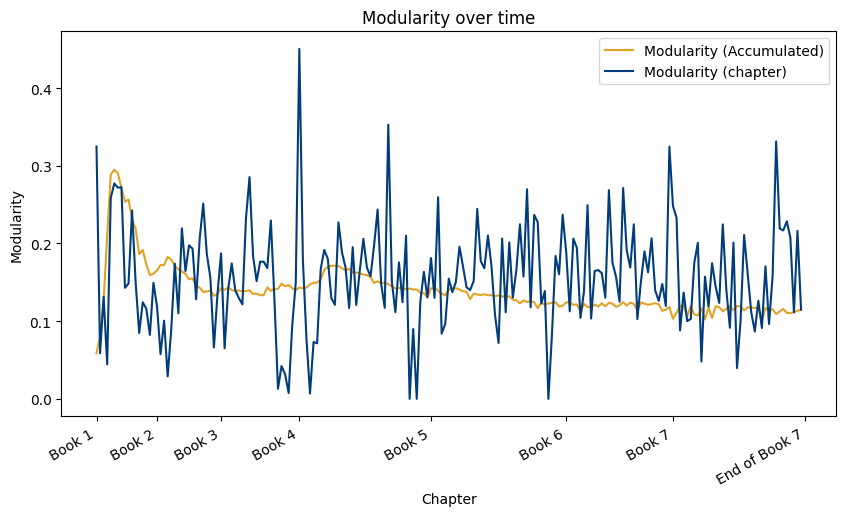

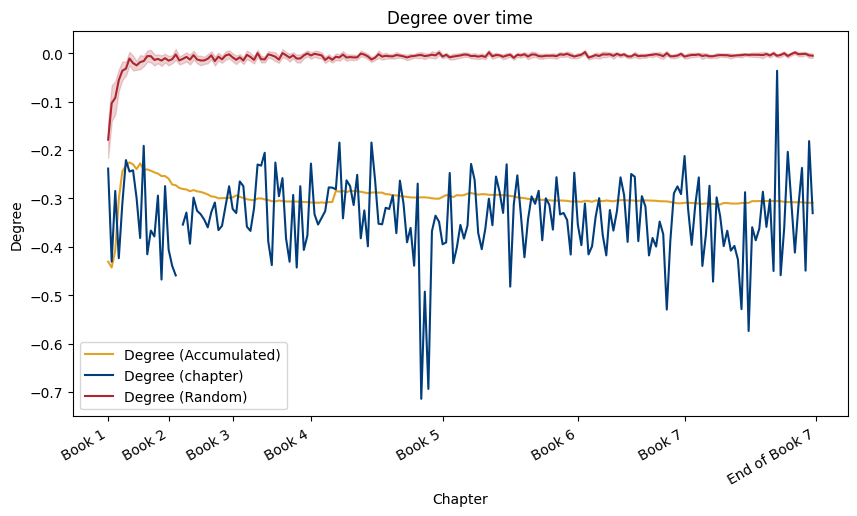

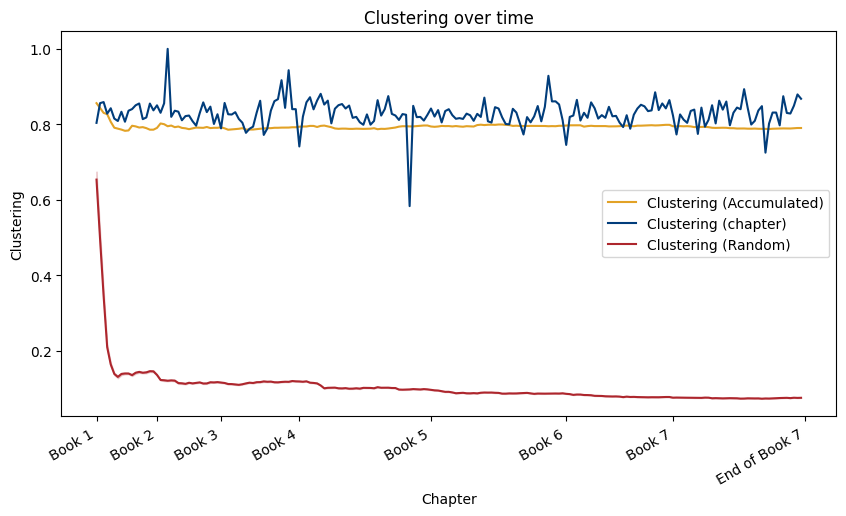

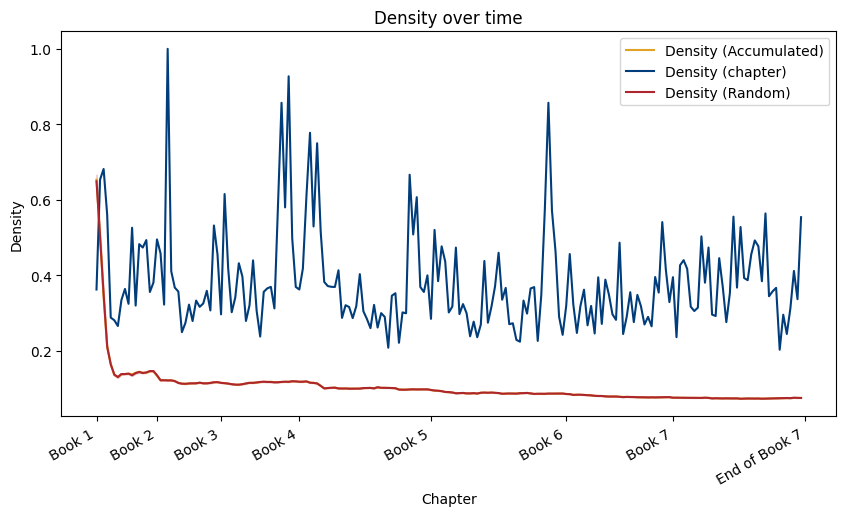

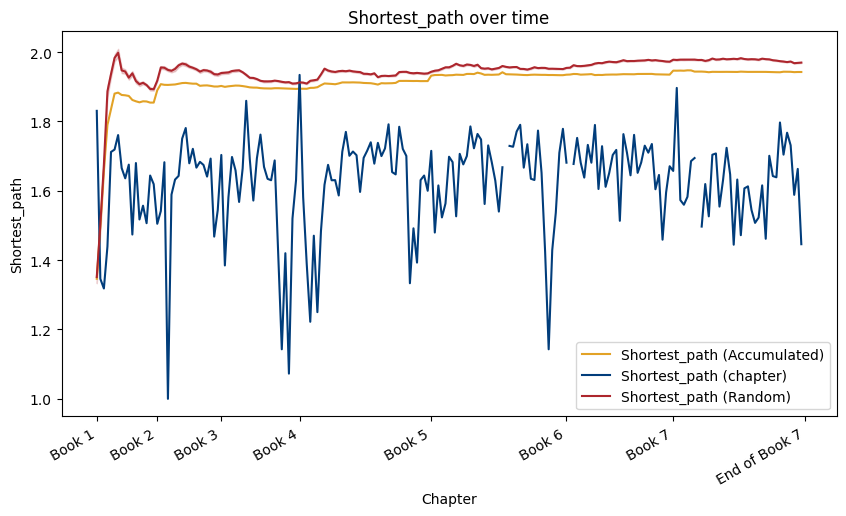

In [31]:
n_chapters = {1 : 17, 2 : 18, 3 : 22, 4 : 37, 5 : 38, 6 : 30, 7 : 37}
combinations = list()
for book_nr in range(1,8):
    for chapter_nr in range(1,n_chapters[book_nr]+1):
        combinations.append((book_nr,chapter_nr))

random, cumulative, chapter = list(), list(), list()

centrality_cumulative, centrality_chapter = {char: list() for char in final_character_list.Name}, {char: list() for char in final_character_list.Name}

for comb in combinations:
    r, cu, cm, ccu, cch = get_overall_network_stats(comb[0],comb[1])

    random.append(r)
    cumulative.append(cu)
    chapter.append(cm)
    for char in final_character_list.Name:
        centrality_cumulative[char].append(ccu.get(char, 0))
        centrality_chapter[char].append(cch.get(char, 0))

for stat in cumulative[0].keys():
    if stat == "Modularity":
        plot_network_stat([x[stat] for x in cumulative], [x[stat] for x in chapter], None, stat, stat)
    else:
        plot_network_stat([x[stat] for x in cumulative], [x[stat] for x in chapter], [x[stat] for x in random], stat, stat)

#### Centrality of main characters

In order to asses the centrallity of the main characters we use the following functions, we compute the centrallity for each of the following characters:

    ['Harry Potter', "Severus Snape", 'Albus Dumbledore', "Lord Voldemort", "Hermione Granger","Ginny Weasley" ,"Ron Weasley", "Neville Longbottom"]
    
The centrallity measure is their degree centrallity, and is computed for each chapter and the accumulated network for that chapter.

In [68]:
display_chars = ['Harry Potter', "Severus Snape", 'Albus Dumbledore', "Lord Voldemort", "Hermione Granger","Ginny Weasley" ,"Ron Weasley", "Neville Longbottom"]
n_chapters = {1 : 17, 2 : 18, 3 : 22, 4 : 37, 5 : 38, 6 : 30, 7 : 37}

def plot_character_centrality_v1(display_chars, centrality_cumulative):
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    for i, char in enumerate(display_chars):
        ax.plot(centrality_cumulative[char], label=char, color=colors[i])

    ax.set_xticks([0, *[sum(list(n_chapters.values())[:i]) for i in range(1,8)]], labels = [*[f"Book {i}" for i in range(1,8)], "End of Book 7"])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.set_xlabel("Chapter")
    ax.set_ylabel("Degree centrality")
    ax.set_title("Degree centrality over time")

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)

    plt.show()

def plot_character_centrality_v2(display_chars, centrality_cumulative, centrality_chapter):
    fig, ax = plt.subplots(4, 2, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

    for i, char in enumerate(display_chars):
        axs = ax[i % int(len(display_chars)/2), i // int(len(display_chars)/2)]
        axs.plot(centrality_cumulative[char], label= "Accumulated", color=colors[0])
        axs.plot(centrality_chapter[char], label= "Chapter", color=colors[1])
        axs.set_xticks([])
        axs.set_title(char)

    for j in range(2):
        ax[3, j].set_xticks([0, *[sum(list(n_chapters.values())[:i]) for i in range(1,8)]], labels = [*[f"Book {i}" for i in range(1,8)], "End of Book 7"])
        plt.setp(ax[3, j].get_xticklabels(), rotation=30, horizontalalignment='right')
        ax[3, j].set_xlabel("Chapter")

    fig.legend(*ax[0,1].get_legend_handles_labels(), loc='upper right')
    
    for axs in ax[:,0]:
        axs.set_ylabel("Degree centrality")

    for axs in ax[:,1]:
        axs.set_yticks([])

    plt.show()

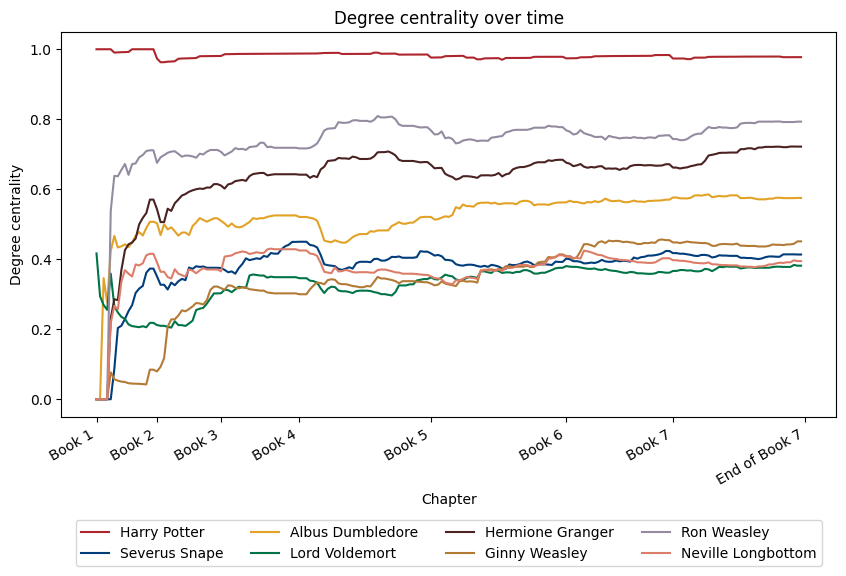

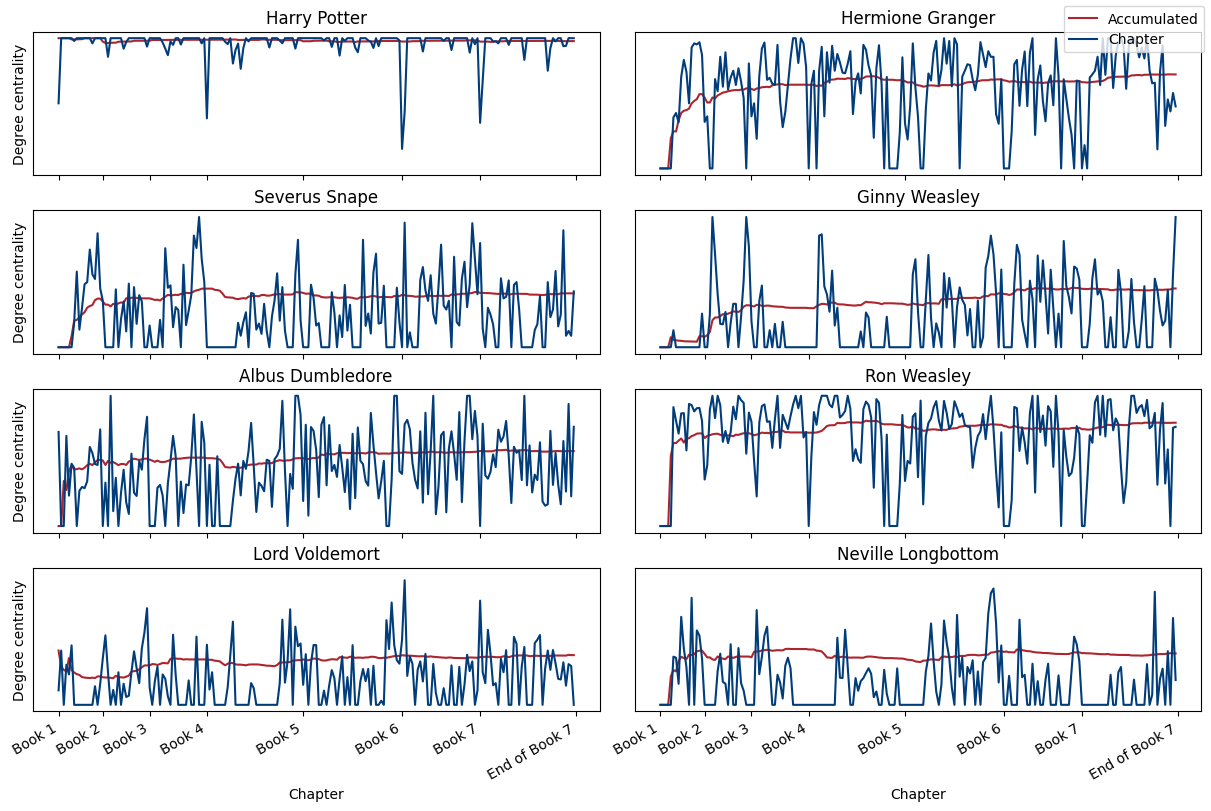

In [69]:
plot_character_centrality_v1(display_chars, centrality_cumulative)
plot_character_centrality_v2(display_chars, centrality_cumulative, centrality_chapter)

### Walktrough of the network analysis methods

In this section we will go through the methods used for the network analysis of the key moments. We will present the methods and the theory behind them, and showcase how we have implemented them in our code.

The main idea behind the analysis of the key moments, is to analyze the graph before and after a big moment.

#### Comparing changes in the community structure of the Character Network

Following our data has no direct attribute in which the characters can be split into communities, we use a partioning algorithm. Comparing modularity scores at different chapter points yields no clear insight to how community representation of the network has changed. Instead we compare compare how characters have changed communities from the previous partitioning. This is done through `get_community_matrix(previous, current)` which takes two partitions of networks at different points. following that, the network is not guaranteed to have the same nodes at different points in the history the function takes the union of the nodes in the two partitions. From this, it then constructs a matrix representing how the previous communites have been divided into the current communities. The values in the matrix are the number of characters that have changed communities from the previous partition to the current partition. This matrix can then be used to compare the community structure of the network at different points in the history.

In [137]:
def get_community_matrix(previous, current):

    # Get number of communities
    N_previous = len(set(previous.values())) + 1
    N_current = len(set(current.values())) + 1

    # Get characters that are in both chapters
    characters = set(previous.keys() & current.keys())
    
    # Construct matrix
    M = np.zeros((N_previous, N_current))

    # Fill matrix
    for char in characters:
        if previous[char] != "Not present in previous chapter" and current[char] != "Not present in current chapter":
            M[previous[char], current[char]] += 1

    return M

def plot_community_matrix(M, title):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(M, cmap = 'Reds')
    
    # plot options
    ax.set_xticks(np.arange(M.shape[1]))
    ax.set_yticks(np.arange(M.shape[0]))
    ax.set_xticklabels([f"Community {i}" for i in range(M.shape[1])])
    ax.set_yticklabels([f"Community {i}" for i in range(M.shape[0])]) 
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            c = M[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    
    plt.show()

#### Distribution of the Community Structure

The function `get_community_distribution(G1, G2, ...)` take two networks and returns their individual community distributions displayed as a bar plot with count of characters in each community on the y-axis and the community label on the x-axis. 

This allows for a visual comparison and understanding of how the community structure of the network has changed over time.

In [117]:
def community_distribution(G1, G2, title1, title2):

    fig, ax = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle("Community distribution")
    titles = [title1, title2]

    for i, G in enumerate([G1, G2]):
        community = [G.nodes[node]['group'] for node in G.nodes]
        ax[i].bar(range(0, max(community) + 1), [community.count(i) for i in range(max(community) + 1)], color = colors[i])
        
        # plot options
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Community")
        ax[i].set_ylabel("Frequency")
        ax[i].set_xticks(range(0, max(community) + 1), labels= [f"Community {i}" for i in range(max(community) + 1)])
        plt.setp(ax[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    plt.show()

#### Central Characters

In order to access the most-influential characters both in the complete graph and within it's communities the following functions are used:

`get_central_characters(G, top_n = 10)` takes a network and returns a list of the `top_n` most central characters in the network. The centrality measure used is the degree centrality. This is the number of edges connected to a node. This measure is used as it is a simple measure of the importance of a node in a network and Labatut & Bost (2019) note in their litterature review of analysis methods for Fictional Character Networks that degree centrality is generally considered one of the most discriminative centrality measures, thus lending itself very well to character network analysis. The higher the degree centrality of a node the more connected it is to other nodes in the network. This means that the node is more important in the network as it is more likely to be involved in the flow of information in the network.

`get_central_nodes_community(G, community, top_n = 5)` takes a network and a community and returns a list of the `top_n` most central characters for each community.

References:
* Labatut, V. & Bost, X. (2019). Extraction and Analysis of Fictional Character Networks: A Survey. ACM Comput. Surv. 52, 5, Article 89 (September 2019), 40 pages.
https://doi.org/10.1145/3344548

In [22]:
def get_central_nodes(G, top_n=10):

    centrality = nx.degree_centrality(G)
    central_nodes = sorted(centrality, key=centrality.get, reverse=True)[:top_n]

    return central_nodes


def get_central_nodes_community(G, part, top_n=5):

    centrality = nx.degree_centrality(G)
    
    central_nodes = dict()
    for community in set(part.values()):
        central_nodes[community] = sorted([node for node in centrality if part[node] == community], key=centrality.get, reverse=True)[:top_n]

    return central_nodes

#### Distribution of node degrees and interactions between characters compared to character significance

The function `degree_distribution` takes two networks and returns a plot of the node degree distributions. Generally, we would expect that the degree distribution follows the power law, which fits the assumption that there are many more minor characters than primary ones in the Harry Potter books.

Degree matrix is a matrix that shows the number of interactions between characters. The function `degree_matrix` takes a network and returns a plot of the distribution of interactions between characters.

In [136]:
def degree_distribution(G1, G2, title1, title2, N_bins = 50, log = True):

    fig, ax = plt.subplots(1,2,figsize = (15,5))
    fig.suptitle("Degree distribution")

    titles = [title1, title2]

    for i, G in enumerate([G1, G2]):
        degrees = [G.degree(node) for node in G.nodes]

        # Plot the distribution
        bins = np.logspace(0, np.log10(max(degrees)), N_bins)
        hist, edges = np.histogram(degrees, bins=bins, density=True)
        x = (edges[1:] + edges[:-1])/2
        x = x[hist>0]
        hist = hist[hist>0]

        ax[i].plot(x, hist, marker = ".", color = colors[i])
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Node Degree")
        ax[i].set_ylabel("Probability Density")

        if log:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")

    plt.show()


def degree_matrix(G1, G2, title1, title2):

    fig, ax = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle("Degree Assortativity Matrix")
    titles = [title1, title2]

    for i, G in enumerate([G1, G2]):
        degree_matrix = nx.degree_mixing_matrix(G)

        ax[i].imshow(degree_matrix, cmap="BuGn")
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Degree")
        ax[i].set_ylabel("Degree")

        N = len(degree_matrix)
        ax[i].set_xticks(range(0,N,10))
        ax[i].set_xticklabels(range(1,N+1,10))
        ax[i].set_yticks(range(0,N,10))
        ax[i].set_yticklabels(range(1,N+1,10))

    plt.show()

#### Accessing significance of the network partitioning

In order to test for significanse of the proposed optimal partioning, the function `modularity_test` takes two graphs and uses the double swap algorithem to compute the modularity of a corresponding randomized edges graph.

In [24]:
def modularity_test(G1, G2, partition1, partition2, title1, title2, N_bins = 20):

    fig, ax = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle("Modularity distribution of Swapped Graphs")
    titles = [title1, title2]

    for i, (G, partition) in enumerate(zip([G1, G2], [partition1, partition2])):
        modularity_values = ex_modularity(G, partition, n_swap=1000, experiments=100)

        bins = np.linspace(min(modularity_values), max(modularity_values), N_bins)
        hist, edges = np.histogram(modularity_values, bins=bins, density=True)
        x = (edges[1:] + edges[:-1])/2
        width = bins[1] - bins[0]

        ax[i].bar(x, hist, width=width, alpha=0.5, color = colors[0])
        ax[i].axvline(x=community_louvain.modularity(partition,G), color='black', linestyle='--', linewidth=2)
        ax[i].legend(['Original Modularity', 'Randomized Modularity'])
        ax[i].set_title(titles[i])
        ax[i].set_xlabel('Modularity')
        ax[i].set_ylabel('pdf')

    plt.show()

#### Calling the tools on different key moments

All key moments are defined as having a period of chapters pre-moment and post-moment. The following wrapper function is used to call the above functions on each key moment:

In [141]:
def get_key_moment_stats(pre: tuple = (1, 1, 4), post: tuple = (1, 1, 17), include_mod_degrees: bool = False):
    G_pre,_,partition_pre,_ = get_network_state(pre[0], pre[2], book_only = True, chapter_from=pre[1])
    G_post,_,partition_post,_ = get_network_state(post[0], post[2], book_only = True, chapter_from=pre[1])

    # Get central nodes
    central_nodes_pre = get_central_nodes(G_pre)
    central_nodes_post = get_central_nodes(G_post)

    # Get central nodes from each community
    central_nodes_community_pre = get_central_nodes_community(G_pre, partition_pre)
    central_nodes_community_post = get_central_nodes_community(G_post, partition_post)

    # Display community distribution
    community_distribution(G_pre, G_post, f"Community distribution chapter {pre[1]}-{pre[2]}", f"Community distribution chapter {post[1]}-{post[2]}")

    # Display communities change matrix
    M = get_community_matrix(partition_pre, partition_post)
    plot_community_matrix(M, f"Change in communites from chapter {pre[1]}-{pre[2]} to chapter {post[1]}-{post[2]}")

    # Display central nodes
    print(f"Central nodes of the graph of the first {pre[2]} chapters :")
    print(central_nodes_pre)

    print(f"Central nodes of the graph of the first {post[2]} chapters :")
    print(central_nodes_post)

    # Display central nodes from each community
    print(f"Central nodes from each community of the graph of the first {pre[2]} chapters :")
    for community in central_nodes_community_pre.keys():
        print(f"Community {community} : {central_nodes_community_pre[community]}")


    print(f"Central nodes from each community of the graph of the first {post[2]} chapters :")
    for community in central_nodes_community_post.keys():
        print(f"Community {community} : {central_nodes_community_post[community]}")
    
    if include_mod_degrees:
        title1, title2 = f"Chapters {pre[1]}-{pre[2]}", f"Chapters {post[1]}-{post[2]}"
        modularity_test(G_pre, G_post, partition_pre, partition_post, title1=title1, title2=title2)
        degree_distribution(G_pre, G_post, title1=title1, title2=title2)
        degree_matrix(G_pre, G_post, title1=title1, title2=title2)

### Visualizing the networks

For vizualization of the network we use the `netwulf` package. This package allows for interactive vizualization of the network. The color of the nodes in the network is determined by their assignment to community (Thus nodes of same color are in the same community). The size of the nodes is determined by how many times the character appears trough the text (An apperance increments the node size by +1). The width of the edges represents how many times that specfic edge appeared on a page in the text.

Further labels for chosen nodes are displayed. This character can be highligthed either by appearing significant withn a community or by being a known central character in the books.

### Network results

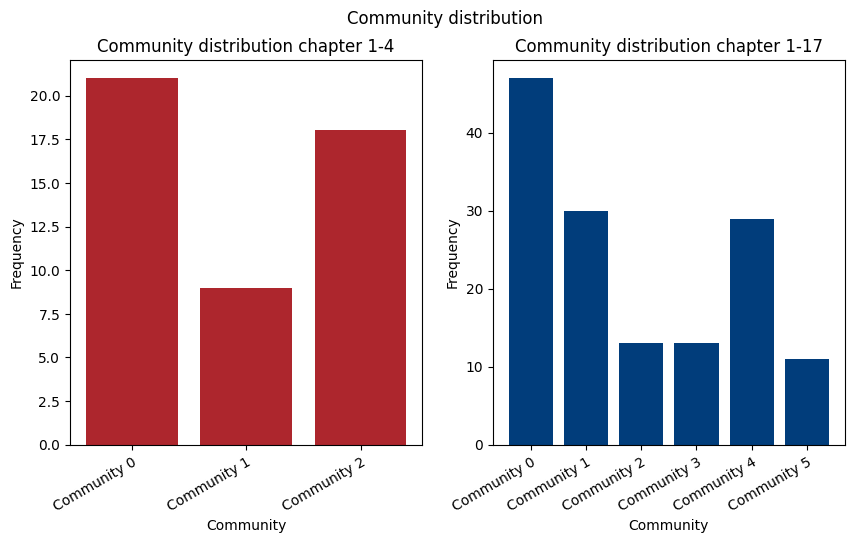

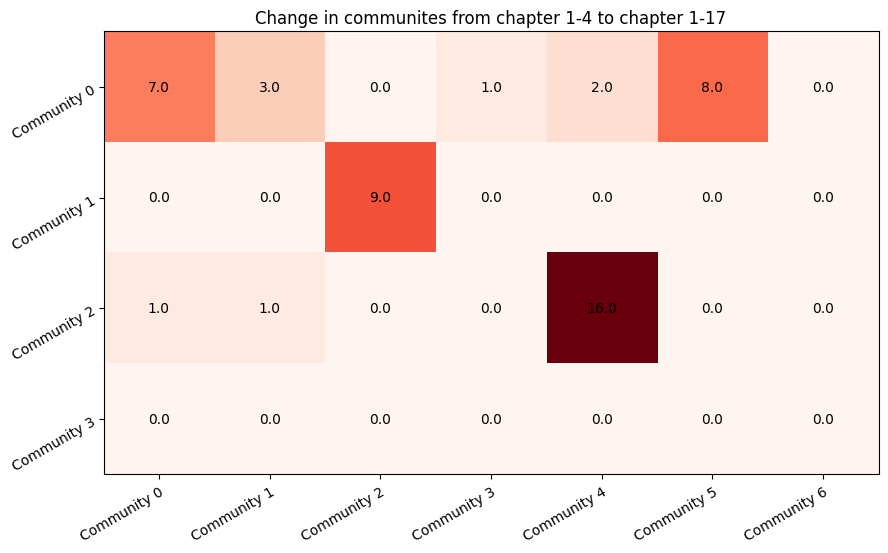

Central nodes of the graph of the first 4 chapters :
['Harry Potter', 'Rubeus Hagrid', 'Dudley Dursley', 'Vernon Dursley', 'Petunia Dursley', 'Three Muggle boys', 'Stan Shunpike', 'Albus Dumbledore', 'Arabella Figg', 'Gringotts Head Goblin']
Central nodes of the graph of the first 17 chapters :
['Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Rubeus Hagrid', 'Albus Dumbledore', 'Minerva McGonagall', 'Neville Longbottom', 'Draco Malfoy', 'George Weasley', 'Severus Snape']
Central nodes from each community of the graph of the first 4 chapters :
Community 0 : ['Rubeus Hagrid', 'Albus Dumbledore', 'Gringotts Head Goblin', 'Lord Voldemort', 'Wizard who claimed to be a dragon killer']
Community 1 : ['Three Muggle boys', 'Stan Shunpike', 'Phyllida Spore', 'Emeric Switch', 'Bathilda Bagshot']
Community 2 : ['Harry Potter', 'Dudley Dursley', 'Vernon Dursley', 'Petunia Dursley', 'Arabella Figg']
Central nodes from each community of the graph of the first 17 chapters :
Community 0 : ['Harry P

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


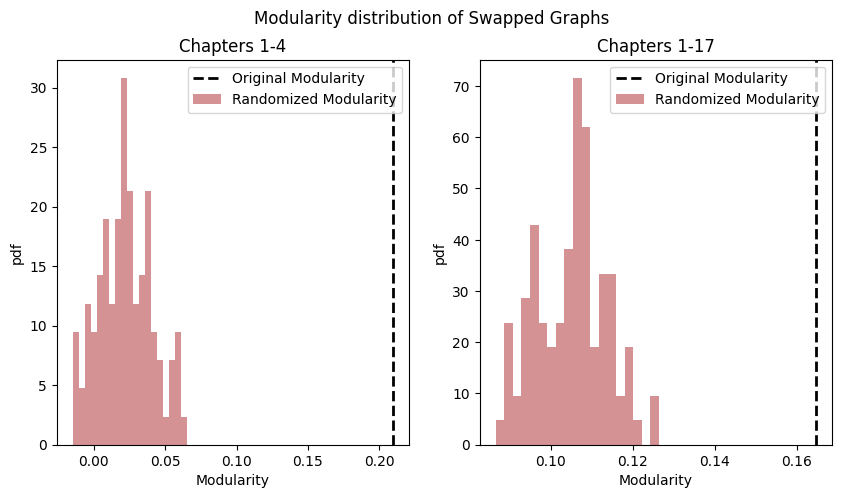

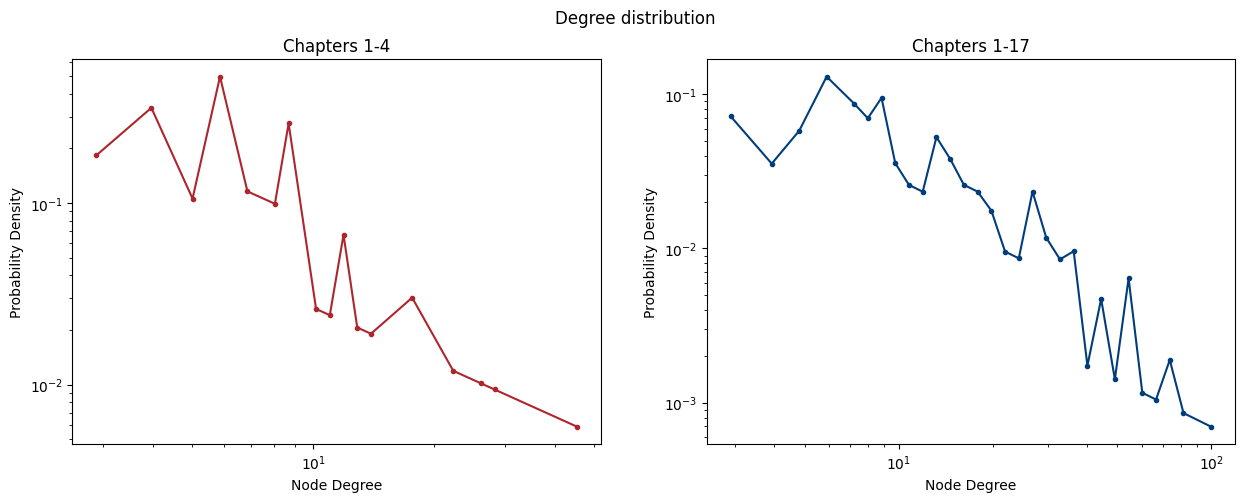

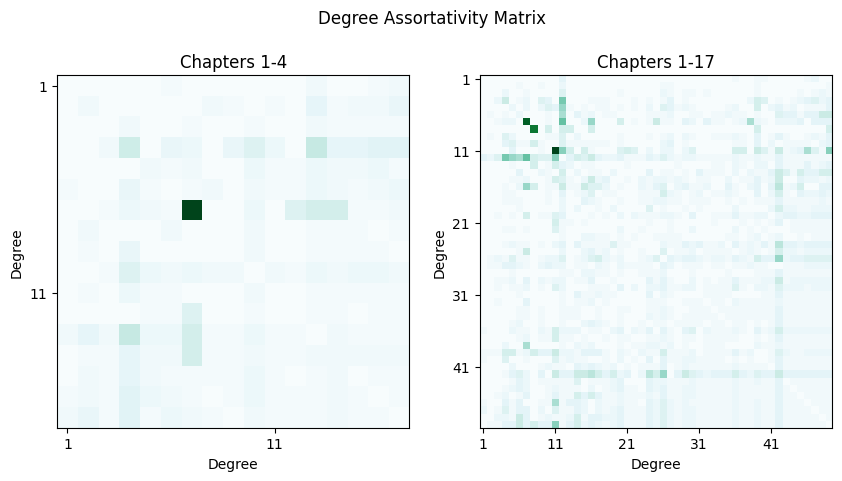

In [142]:
# Muggles vs Wizards
get_key_moment_stats((1,1,4), (1,1,17), include_mod_degrees=True)

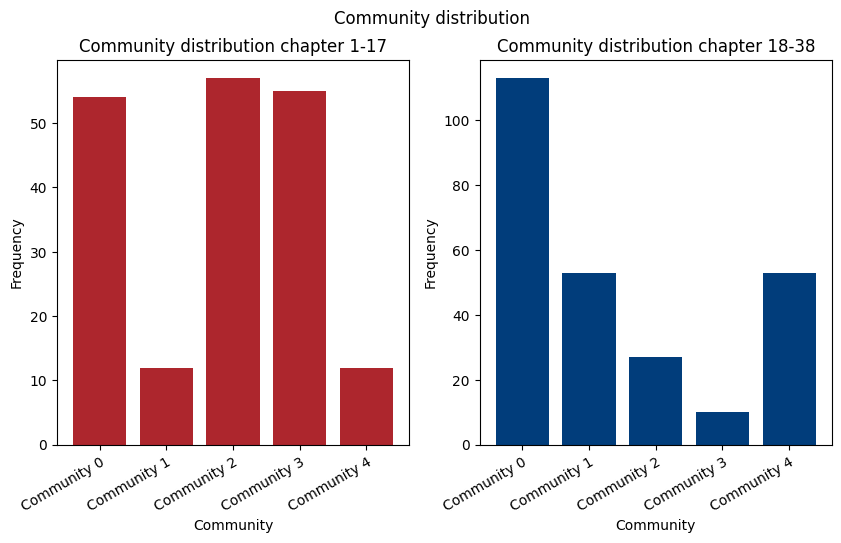

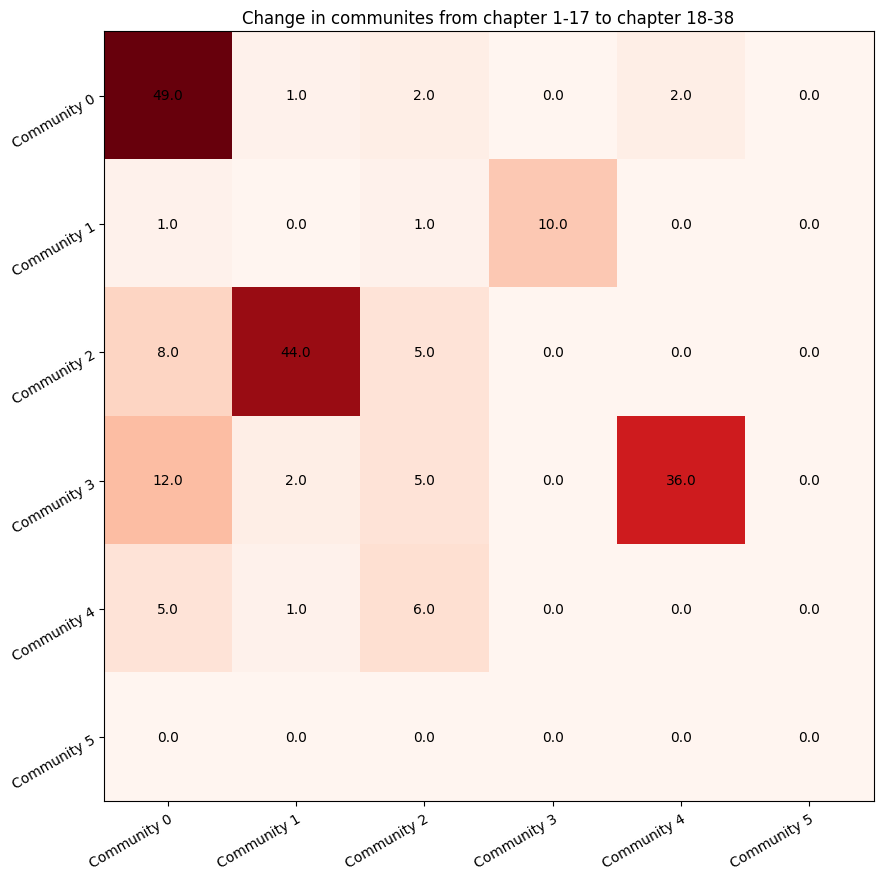

Central nodes of the graph of the first 17 chapters :
['Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Albus Dumbledore', 'Sirius Black', 'Fred Weasley', 'Dolores Umbridge', 'George Weasley', 'Ginny Weasley', 'Neville Longbottom']
Central nodes of the graph of the first 38 chapters :
['Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Albus Dumbledore', 'Dolores Umbridge', 'Sirius Black', 'Neville Longbottom', 'George Weasley', 'Fred Weasley', 'Ginny Weasley']
Central nodes from each community of the graph of the first 17 chapters :
Community 0 : ['Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Albus Dumbledore', 'Dolores Umbridge']
Community 1 : ['Lord Voldemort', 'Dudley Dursley', 'Vernon Dursley', 'Three Muggle boys', 'Petunia Dursley']
Community 2 : ['Sirius Black', 'Remus Lupin', 'Wizard who claimed to be a dragon killer', 'Molly Weasley', 'Arthur Weasley']
Community 3 : ['Fred Weasley', 'George Weasley', 'Ginny Weasley', 'Neville Longbottom', 'Cho Chang']
Community 4 : [

100%|██████████| 100/100 [02:49<00:00,  1.69s/it]


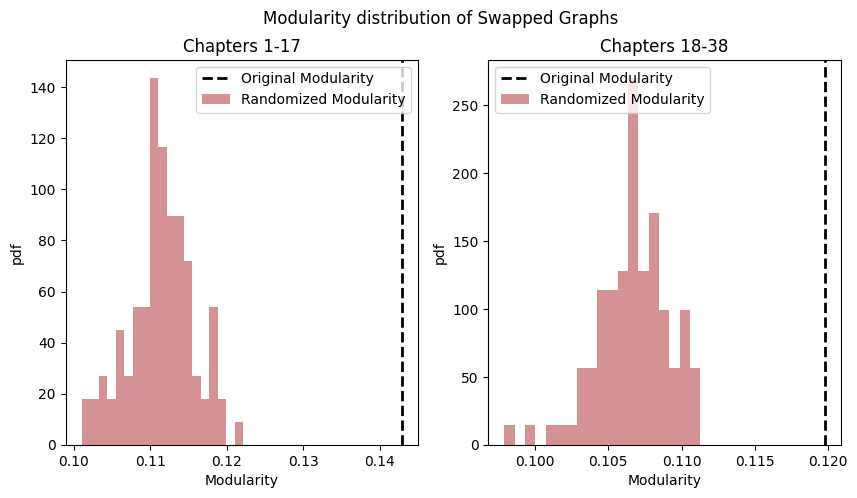

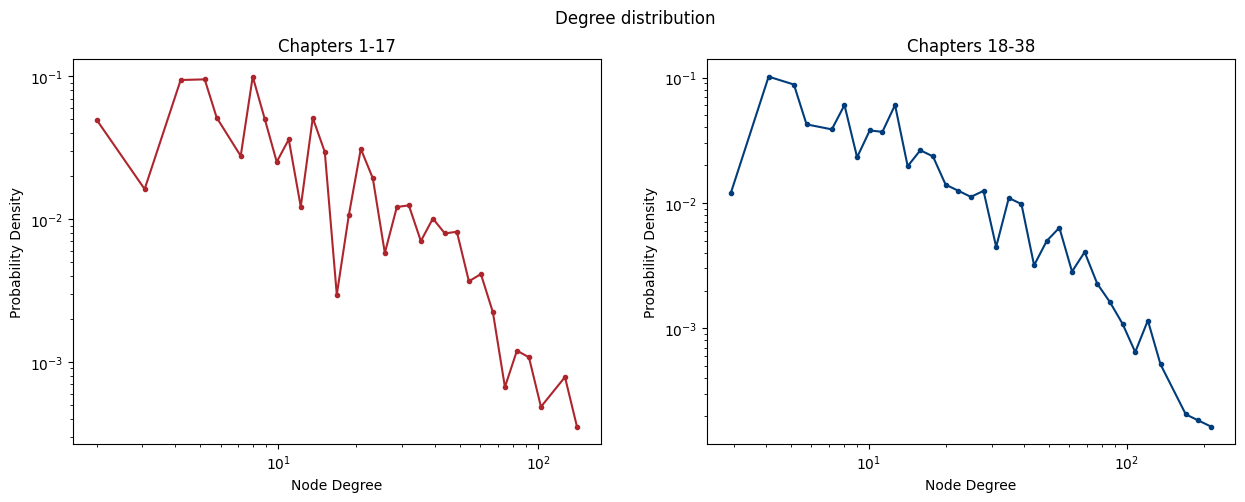

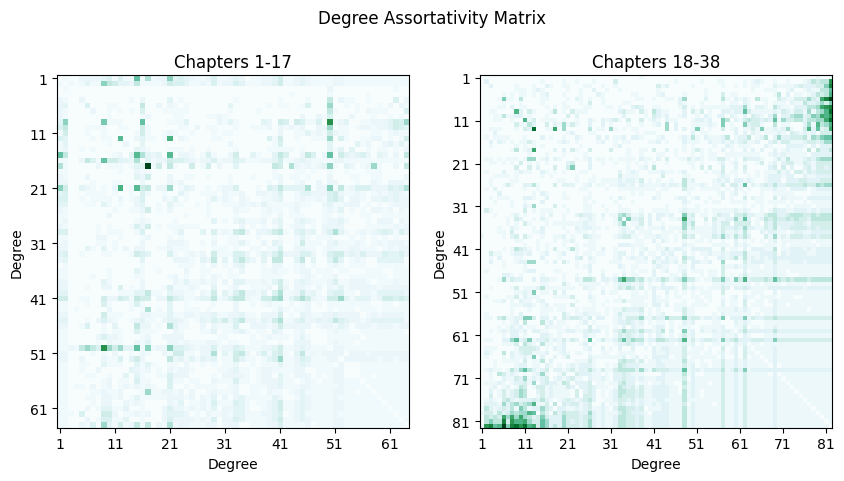

In [143]:
# Dumbledore's Army
get_key_moment_stats((5,1,17), (5,18,38), include_mod_degrees=True)

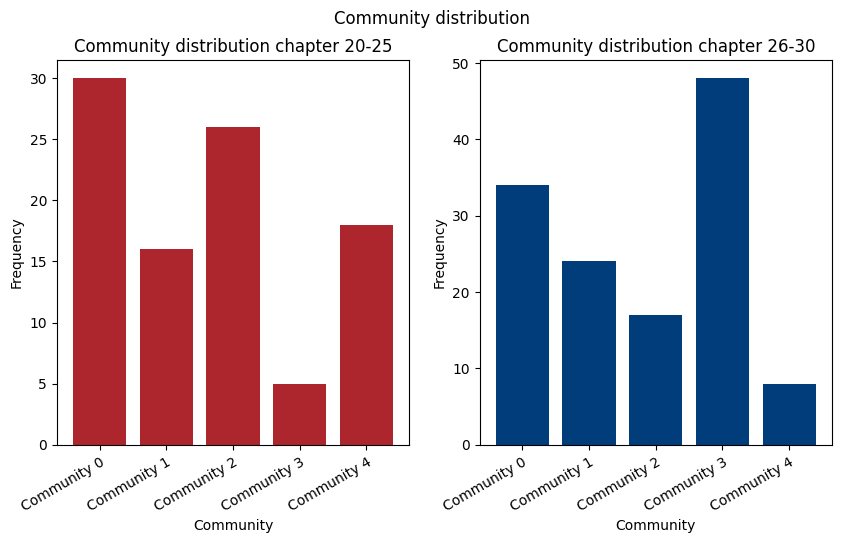

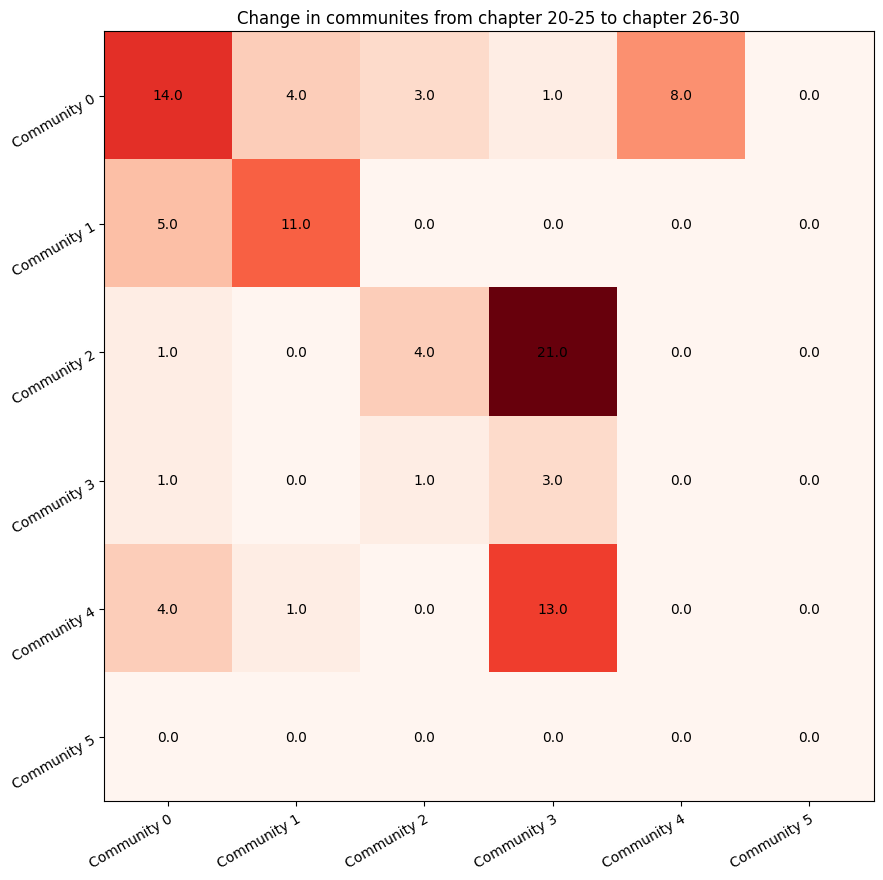

Central nodes of the graph of the first 25 chapters :
['Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Albus Dumbledore', 'Severus Snape', 'Horace Slughorn', 'Draco Malfoy', 'Ginny Weasley', 'Lavender Brown', 'Rubeus Hagrid']
Central nodes of the graph of the first 30 chapters :
['Harry Potter', 'Albus Dumbledore', 'Ron Weasley', 'Hermione Granger', 'Severus Snape', 'Ginny Weasley', 'Draco Malfoy', 'Horace Slughorn', 'Minerva McGonagall', 'Rubeus Hagrid']
Central nodes from each community of the graph of the first 25 chapters :
Community 0 : ['Harry Potter', 'Albus Dumbledore', 'Severus Snape', 'Cho Chang', 'Sirius Black']
Community 1 : ['Horace Slughorn', 'Rubeus Hagrid', 'Argus Filch', 'Riddle House', 'Tom']
Community 2 : ['Ron Weasley', 'Hermione Granger', 'Ginny Weasley', 'Lavender Brown', 'Dean Thomas']
Community 3 : ['Three Muggle boys', 'Rosmerta', 'Madam Malkin', 'Wilkie Twycross', 'Puddifoot']
Community 4 : ['Draco Malfoy', 'Inferi Army of Lord Voldemort', 'Gregory Goyle',

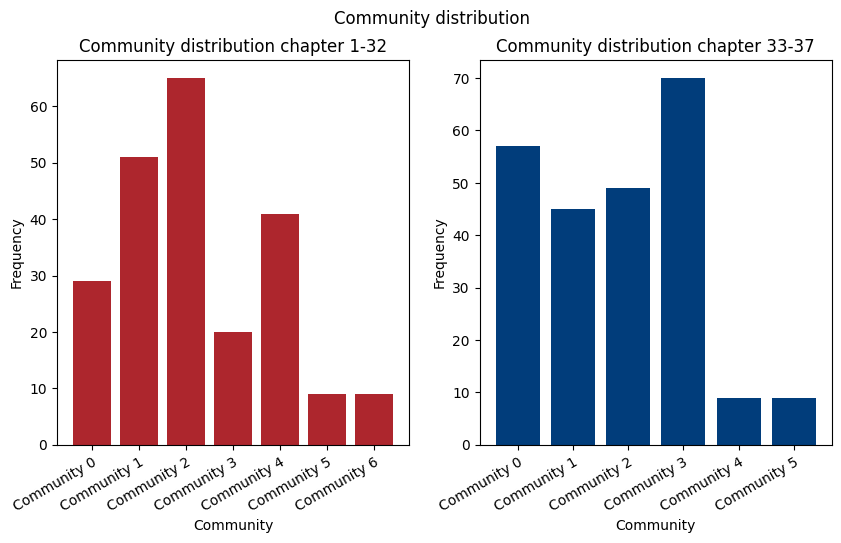

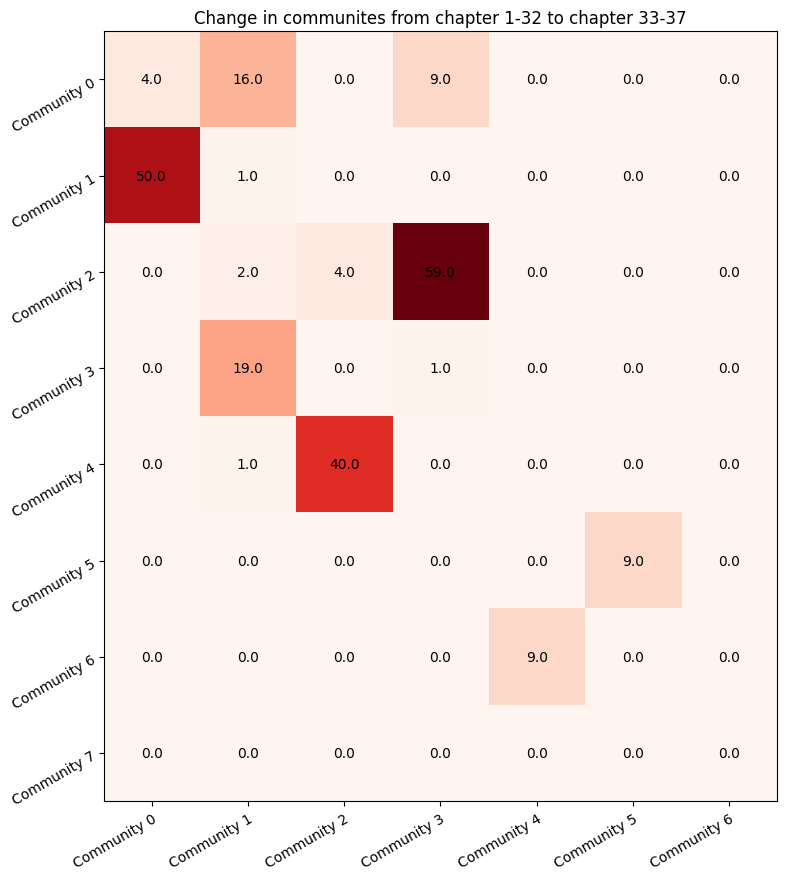

Central nodes of the graph of the first 32 chapters :
['Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Albus Dumbledore', 'Death', 'Lord Voldemort', 'Severus Snape', 'Remus Lupin', 'Wizard who claimed to be a dragon killer', 'Luna Lovegood']
Central nodes of the graph of the first 37 chapters :
['Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Albus Dumbledore', 'Death', 'Lord Voldemort', 'Remus Lupin', 'Ginny Weasley', 'Severus Snape', 'Luna Lovegood']
Central nodes from each community of the graph of the first 32 chapters :
Community 0 : ['Lord Voldemort', 'Griphook', 'Bellatrix Lestrange', 'Draco Malfoy', 'Dean Thomas']
Community 1 : ['Remus Lupin', 'Rubeus Hagrid', 'Fleur Delacour', 'Fred Weasley', 'Ginny Weasley']
Community 2 : ['Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Death', 'Sirius Black']
Community 3 : ['Luna Lovegood', 'Neville Longbottom', 'Minerva McGonagall', 'Cho Chang', 'Amycus Carrow']
Community 4 : ['Albus Dumbledore', 'Severus Snape', 'Wizard who cla

In [144]:
# Snape's True Allegiance
get_key_moment_stats((6,20,25), (6,26,30), include_mod_degrees=False)
get_key_moment_stats((7,1,32), (7,33,37), include_mod_degrees=False)

## Tools and theory for Text analysis

### Getting the dynamic character text for a specific character

In order to get the text for some specific characters between two chapters, we use the function `get_text(start, stop, characters_to_get)`, where `start` and `stop` are lists of `[book_nr, chapter_nr]` and `characters_to_get` is a list of of all characters we want to get the text from. The function traverses the text between the two chapters and returns a dictionary of lists of strings (broken down to character apperances), where the text given by `dict[character name][book_nr][chapter_nr]` and the book and chapter locations are relative to the start point.

In [84]:
# Get the vocabulary of all characters
books = {nr: [] for nr in range(1,8)}
for book_nr in range(1,8):
        # Load formatted book (dict of chapters with list of lists of pages and sentences)
    with open(f"Data/Books formatted/Book{book_nr}.pkl","rb") as f:
        book = pkl.load(f)

    for chapter in book.values():
        for page in chapter:
            books[book_nr].extend([token for sent in page for token in tokenize(sent)])

def get_text(start: list = [1, 1], stop: list = [7, 37], characters_to_get: list = [], alltexts: dict = book_text) -> dict:
    
    text_dict = {name: [] for name in characters_to_get}
    
    for char in characters_to_get:
        temp = {booknr: alltexts[char].get(booknr) for booknr in range(start[0], stop[0]+1)}
        for booknr in range(start[0], stop[0]+1):
            if start[0] == stop[0]:
                # add the text from the start to stop chapters of that one book 
                text_dict[char].append([text['text'] for text in itemgetter(*range(start[1], stop[1]+1))(temp[booknr])])
            
            else: 
                if booknr == start[0]:
                    # add the text from the start book starting from the start chapter to the end
                    text_dict[char].append([text['text'] for text in itemgetter(*range(start[1], len(temp[booknr])+1))(temp[booknr])])
                elif booknr == stop[0]:
                    # add the text from the stop book starting from the start to the stop chapter
                    text_dict[char].append([text['text'] for text in itemgetter(*range(1, stop[1]+1))(temp[booknr])])
                else:
                    # add the text from the middle books completely
                    text_dict[char].append([text['text'] for text in temp[booknr].values()])
    return text_dict

### TF-IDF
The first component to all text analysis is gaining a good understanding for the dynamical text related to a specific character, by using text mining, specifically, Term Frequency-Inverse Document Frequency (TF-IDF). 

The overarching ambition with this text analysis, is to plot the wordclouds for the context text of a specific character, at a specific time. When plotting a word cloud for a character it may seem intuitive to select the most occuring words surrounding that character, to get the best impression of the character itself. However, this is rarely the case for larger corpi. This is because the most common words for a character will usually not be specific to that character. Therefore, it is important to not just consider how often a term appears in a given document, but weighting it based on how many other documents it also appears in. This weighting of importance is known as the TF-IDF statistic.

#### Pre-processing for TF-IDF
To support fast computations, it can be an advantage to pre-calculate the total vocabulary of all terms present in the corpus, and the document term count for each of the character chapter text instances. This was done using:

```python
all_words = set()
for book in books.values():
        all_words = all_words.union(book)

# Get document term count (document = chapter)
def get_doc_term_count(documents: dict = book_text, all_terms: set = all_words):
    doc_term_count = {}
    for term in tqdm(all_terms):
        for char in documents.keys():
            for book in documents[char].values():
                doc_term_count.update({term: doc_term_count.get(term, 0) + sum([1 for chapter in book.values() if term in chapter['tokens']])})

    return doc_term_count

doc_term_count = get_doc_term_count()

# Get document term count (document = book)
def get_doc_term_count_books(documents: dict = books, all_terms: set = all_words):
    doc_term_count_book = {}
    for term in tqdm(all_terms):
        doc_term_count_book.update({term: sum([1 for book in books.values() if term in book])})

    return doc_term_count_book

doc_term_count_book = get_doc_term_count_books()

```
We instead here load the pre-calculated vocabulary and document term count from the `temp/` folder.

In [85]:
# load the all_word set ad doc_term_count
with open('temp/tf_idf_support.pkl', 'rb') as f:
    all_words, doc_term_count, doc_term_count_book = pkl.load(f)

#### Implementation of TF-IDF

Here the term frequency `TF(t,d)` is calculated by the formula:

$tf(t,d) = \frac{f_{t,d}}{\sum_{t' \in d}(f_{t',d})}$

Which is implemented in `calc_tf()`. 
The inverse document frequency `IDF(t,D)` can be calculated by the formula:

$IDF(t,D) = \log{\frac{N}{|\{d \in D : t \in d \}|}}$

This has also been implemented in the `calc_idf()` function below. The final step is to multiply TF with IDF to get the TFIDF, which is implemented in the function `calc_tf_idf()`.

Note: the `cumulative` parameter in the functions is used to determine whether to calculate the TF-IDF of a character of the cumulative books. To calculate the YF-IDF for the books set `cumulative = True` in the function call.

This can then be used to sort which words should be weighted the highest in the word clouds for each character, which should in turn give the best pictures of said characters.

In [87]:
# Calculate tf
def calc_tf(character: str = "", position: Union[list, int] = [1,1], documents: tuple = (book_text, books), cumulative: bool = False):
    if cumulative:
        documents = documents[1]
        terms = documents[position]
    else:
        documents = documents[0]
        terms = documents[character][position[0]][position[1]]['tokens']
    
    frequency = nltk.FreqDist(terms)

    sum_terms = len(terms)
    tf = {word: freq/sum_terms for word, freq in frequency.items() if word not in [el.lower() for char in final_character_list.Name for el in char.split(' ')] + ['said']}

    return tf

# Calculate idf
def calc_idf(position: Union[list, int] = [1,1], documents: tuple = (book_text, books), all_terms: set = all_words,
            doc_term: tuple = (doc_term_count, doc_term_count_book), cumulative: bool = False):
    if cumulative:
        documents = documents[1]
        doc_term = doc_term[1]
        N = len(documents)
    else:
        documents = documents[0]
        doc_term = doc_term[0]
        N = sum([len(documents['Harry Potter'][i]) for i in range(1,8)])*len([char for char in final_character_list.Name])

    idf = {word: np.log2(N/(1 + doc_term[word])) for word in all_terms}

    return idf

# Calculate tf-idf
def calc_tf_idf(character: str = "", position: Union[list, int] = [1,1], cumulative: bool = False):
    if cumulative:
        tf = calc_tf(position = position, cumulative = True)
        idf = calc_idf(position = position, cumulative = True)
    else:
        tf = calc_tf(character = character, position = position, cumulative = False)
        idf = calc_idf(position = position, cumulative = False)

    tf_idf = {word: tf[word] * idf[word] for word in tf.keys()}

    return tf_idf

#### Implementation of Wordclouds
The wordclouds are generated using the `wordcloud` package. The wordclouds are generated using the `generate_wordcloud()` function, which takes a dictionary of words and their TF-IDF scores, and plots a wordcloud of the 100 most important words for that character.

In [110]:
def plot_wordcloud(characters_to_get: list = [], position: list = [1,1], mask: list = None, colormap: list = ["OrRd"]):
    fig, ax = plt.subplots(len(characters_to_get), 1, figsize=(20,10), constrained_layout=True)
    for i, char in enumerate(characters_to_get):
        if mask is not None:
            mask1 = np.array(Image.open(mask[i]))
            mask1 = np.where(mask1==0, 255, mask1)
            wordcloud = WordCloud(background_color="white",
                                mask=mask1,
                                contour_color='black',
                                contour_width=1,
                                colormap=colormap[i]
                                ).generate_from_frequencies(calc_tf_idf(character=char, position=position))
        else:
            wordcloud = WordCloud(background_color="white",
                                    colormap=colormap[i]
                                    ).generate_from_frequencies(calc_tf_idf(character=char, position=position))
        
        ax[i].imshow(wordcloud, interpolation='bilinear')
        ax[i].set_title(f"Wordcloud of {char} in book {position[0]}, chapter {position[1]}", fontsize=20)
        ax[i].axis("off")
    plt.show()

def plot_wordcloud_book(mask: list = None, colormap: list = ["OrRd"]):

    for booknr in range(1,8):
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        if mask is not None:
            mask1 = np.array(Image.open(mask[booknr-1]))
            mask1 = np.where(mask1==0, 255, mask1)
            wordcloud = WordCloud(background_color="white",
                                mask=mask1,
                                contour_color='black',
                                contour_width=1,
                                colormap=colormap[booknr-1]
                                ).generate_from_frequencies(calc_tf_idf(position = booknr, cumulative = True))
        else:
            wordcloud = WordCloud(background_color="white",
                                    colormap=colormap[booknr-1]
                                    ).generate_from_frequencies(calc_tf_idf(position = booknr, cumulative = True))
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        plt.show()

The book wordclouds are than generated for the books as such:

```python
plot_wordcloud_book(mask=['3.Text_files/WordCloud_style/book1.png',
                           '3.Text_files/WordCloud_style/book2.png',
                           '3.Text_files/WordCloud_style/book3.png',
                           '3.Text_files/WordCloud_style/book4.png',
                           '3.Text_files/WordCloud_style/book5_1.png',
                           '3.Text_files/WordCloud_style/book6.png',
                           '3.Text_files/WordCloud_style/book7.png'],
                    colormap=['OrRd', 'BuGn', 'twilight', 'PuBu', 'Wistia', 'BrBG', 'bone'])
```

And for a specific character during a book period as:
```python

plot_wordcloud(characters_to_get, position = [book_nr, chapter_nr], colormap=['OrRd', 'BuGn', 'twilight', 'PuBu', 'Wistia', 'BrBG', 'bone'])
```

### Flesch Reading Ease
One way to measure whether or not the books become more suited to older audiences from book to book is through the language it is written in. Especially since children genereally learn to read harder languages as they become older. But what prompts one text to be harder to read than another? One way to determine how easy a text is to read is through a test called the Flesch's Reading Ease(FRE) test. The FRE score is quantifiable way to measure reading ease through a weighting of the total amount of words(W), the total amount of setences(Se), and the total amount of syllables(Sy). This score can be calculated with the following formula:

$FREs = 206.835 -1.015(\frac{W}{Se}) - 84.6 (\frac{Sy}{Se})$

The scores range from 100 to 0 where the lower the score the harder it is to read. (https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests).

This has been implemented in the function `get_flesch_reading_ease(text)` using the Pyphen module to hyphenate the text to count the syllables.

In [29]:
def get_flesch_reading_ease(text: list) -> float:
    """
    Returns the Flesch reading ease score for a given text.
    
    Input is a list of sentences.
    """
    n_words = sum([len(sent.split(' ')) for sent in text])
    n_sents = len(text)

    hyphenator = pyphen.Pyphen(lang='en_UK')
    n_syllables = 0
    for sent in text:
        sent = sent.lower()
        n_syllables += len([string for string in re.split('-|\s', hyphenator.inserted(sent)) if string != ''])

    return 206.835 - 1.015*(n_words/n_sents) - 84.6*(n_syllables/n_words)

### Sentiment Analysis
Finally, we conduct sentiment analysis on the text surrounding a specific character. This is done using the `VADER` sentiment analysis tool, which is a lexicon and rule-based sentiment analysis tool. It should be noted that VADER has been tuned to sentiments expressed in social media, which might lead to suboptimal performances on the texts in question, as these come from a litterature domain, and thus  that is specifically attuned to sentiments expressed in social media. The tool is implemented in the `nltk` package.

In [30]:
# Get the sentiment of text
def get_sentiment(text: dict) -> dict:

    sid = SentimentIntensityAnalyzer()
    sentiment_mean = {name: [] for name in text.keys()}
    sentiment_se = {name: [] for name in text.keys()}
    
    for char in text.keys():
        for book in text[char]:
            for chapter in book:
                if chapter == []:
                    sentiment_mean[char].append(np.nan)
                    sentiment_se[char].append(np.nan)
                else:
                    chapter_sentiments = []
                    for sentence in chapter:
                        chapter_sentiments.append(sid.polarity_scores(sentence)['compound'])

                    sentiment_mean[char].append(np.nanmean(chapter_sentiments))
                    sentiment_se[char].append(np.nanstd(chapter_sentiments)/np.sqrt(len(chapter_sentiments)))

    return sentiment_mean, sentiment_se

def plot_sentiment(start: list = [1, 1], stop: list = [7, 37], characters_to_get: list = [],
colors: list = colors):
    """
    Plots the sentiment of the characters in the window between start and stop.
    """
    fig, ax = plt.subplots( len(characters_to_get),
                            1, figsize = (25, 10) #*len(characters_to_get))
                            , constrained_layout=True, sharex=True)

    text_dict = get_text(start, stop, characters_to_get)
    sentiment_mean, sentiment_se = get_sentiment(text_dict)
    for i, (char, sentiment) in enumerate(sentiment_mean.items()):
        ax[i].plot(sentiment, label=char, color = colors[i])
        ax[i].fill_between(range(len(sentiment)), sentiment - 1.96*np.array(sentiment_se[char]), sentiment + 1.96*np.array(sentiment_se[char]), alpha = 0.5, color = colors[i])
        ax[i].axhline(0, color='grey', linestyle='--')
        ax[i].set_xlim(0, len(sentiment_mean[characters_to_get[0]])-1)
        ax[i].set_ylim(-1, 1)
        ax[i].set_title(f"Sentiment for {char} between {start[0]}, {start[1]} and {stop[0]}, {stop[1]}")

    chapters = [17, 18, 22, 37, 38, 30, 37]

    # Create xlabel for the plot in the form of "Book x, Chapter x"
    xlabel = []
    curr_book = start[0]
    curr_chapter = start[1]

    for i in range(len(sentiment_mean[characters_to_get[0]])):
        if curr_chapter <= chapters[curr_book-1]:
            xlabel.append(f"Book {curr_book}, Chapter {curr_chapter}")
            curr_chapter += 1
        else:
            curr_book += 1
            curr_chapter = 1
            xlabel.append(f"Book {curr_book}, Chapter {curr_chapter}")
            curr_chapter += 1

    ax[-1].set_xticks(range(len(sentiment_mean[characters_to_get[0]])), xlabel, rotation=90)
    ax[-1].set_ylabel("Sentiment")
    ax[-1].set_xlabel("Book, Chapter")

    plt.show()

## Analysis big picture

### Why do the chosen tools answer our research questions?
xxx

### What were the main takeaways from the analysis?
xxx

### What are the limitations of the analysis?
xxx

# Discussion

## What went well?
xxx
Network methods
- Degree centrality over time
    Degree centrality over time works quite well to show how central characters become with each chapter. Since Harry Potter is usually always a central character, it also gives an idea as to how connected other characters are to Harry.
- Community distributions
    Community distributions are somewhat usefull, however they are limited by the fact that communities aren't labeled which means that characters in community 1 in one network does not correspond to the characters that are present in community 1 in another network. Therfore changes in communities are difficutlt to track over time.
- Community matrix
- Central nodes
    Showing the central nodes of each community is interesting since these characters represent their communities well, which means that we can use these characters to find connections between characters
- Qualitative network analysis
    Working with network graps can be somewhat tricky, as larger graphs are often very hard to interpret
- Degree distrubtions
- Degree assortativity matrix
- Modularity distribtutions

Text methods
- FRE score
    The FRE score generally gives a good sense of how easy a text is to read. However, in a text full of magical encantations and fictitious creatures, FRE may not be entirely comparable to the standard theshholds, although the changes in FRE should still reflect actual reading difficulty.
- Sentiment score
- Word Clouds
    Word clouds are generally good 
- TF-IDF


## Further research:
- exponentiel weight decay, so that recent connections are more influencial.
Temproal networks like the one we use are good at showing the vast amount of interconnections between characters over time. The growing network ensures that central characters in the books become more and more clear. However this also brings issues when wanting to analyse specific parts of the books. This is because changes early in the books have bigger impact on the network compared to some of the final chapters. Therefore it would be nice to add some sort of weight decay to the network weights, so that recent connections in the network always result in the biggest changes to the network. This could be added by exponentially decaying both node sizes and edge weights. This would make examining key moments more interesting, since some past connections would still be present, without distracting from the most recent events.

- death eater/Hogwarts house classification based on connections using neural networks.
Another interesting idea is leveraging communities in the network for deep learning in order to classify characters e.g as whether or not they are death eaters, or which Hogwarts house they belong to. This could perhaps help us show the true allegiance of characters before it is revealed in the books. This could also be used to find more underlying connections between characters that maybe seem unclear.

